In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 
import re
import OurFunctions as of
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'))

# DATA EXPLORATION

Visualization of the overall dataset

In [ ]:
ASD_phenotypic_original

The dataset contains 1112 subjects and has 74 features.

 By a fast view we can see that there are both categorical and numerical values and there are missing values. Also, we can see the presence of the categories DX_GROUP and DSM_IV_TR, that are described from the ABIDE dataset legend as diagnostic, so we will further remove them from the dataset for the model predictor construction.

To have a better view of the information we display the names of the features and the respective types and quantity of non-null values.

In [ ]:
ASD_phenotypic_original.info()

As we can see, there is an important presence of missing values. Also, there are both numerical type features and object type (which is the default way to label the categorical data.)

In order to have a better view of the distribution of the null values, we check the presence of missing values catalogated as None or numpy.NaN

In [ ]:
# Count of the missing values
nan_values = ASD_phenotypic_original.isna().sum()
nan_sorted = nan_values.sort_values(ascending=False)

# We implemented a function "select_columns", that is able to define wich columns are numerical
# and which ones are categorical (also redefine the objects as categorical in the dataset)
numeric_columns, categorical_columns, ASD_phenotypic_original = of.select_columns(ASD_phenotypic_original)

# We plot the distribution of missing values, with the specification of numeric and categorical columns
of.plot_missing_values(nan_sorted, numeric_columns, legend=True)



For the majority of the features the amount of missing values is not depreciable, so we can say that the information that is stored in the feature is not enough to create a reliable classier/cluster algortihm based on it. We will consider eliminate some of these features to avoid introduce misleading information.

Now let's have a look on the general statistics for the numerical attributes.

In [ ]:
ASD_phenotypic_original.describe()

We can notice the presence of "-9999" as minimum value for different features, a value that is commonly used to denote missing data or values out of range, so it should be better to consider them as NaN.

Now that we have an overall view of the dataset, let's start to work on it in order to clean it.

# BALANCING

DX_GROUP and DSM_IV_TR are our targets.
DX_GROUP contains info about the presence (or not) of autism spectrum.
DSM_IV_TR specifyes which kind of autism. 
However, in our invastigation, the DSM_IV_TR results negligible.

In [ ]:

# Calcola il conteggio delle classi per DX_GROUP
class_counts_DX_GROUP = ASD_phenotypic_original['DX_GROUP'].value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Conteggio delle classi per DX_GROUP:")
print(class_counts_DX_GROUP)

# Visualizza la distribuzione delle classi per DX_GROUP
class_counts_DX_GROUP.plot(kind='bar', color='blue')
plt.title('Distribuzione delle classi per DX_GROUP')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.xticks(rotation=0)
plt.show()

# Calcola le proporzioni delle classi per DX_GROUP
class_proportions_DX_GROUP = ASD_phenotypic_original['DX_GROUP'].value_counts(normalize=True)

# Stampa le proporzioni delle classi per DX_GROUP
print("\nProporzioni delle classi per DX_GROUP:")
print(class_proportions_DX_GROUP)



DX_GROUP is balanced.

# DATA CLEANING

First of all, we decided to apart the features that give the diagnosis of the subjects (DX_GROUP and DSM_IV_TR), in order to use them as the control labels. 

In [ ]:
# Drop  columns DX_GROUP e DSM_IV_TR from the original ASD_phenotypic 
ASD_phenotypic = ASD_phenotypic_original.drop(columns=['DX_GROUP', 'DSM_IV_TR'])

# Store them in a new dataset called ASD_clinical
ASD_clinical = ASD_phenotypic_original[['DX_GROUP']]


In [ ]:
ASD_clinical

Also we decide to drop SUB_ID, as it only store the information about the ID of the subject. But before we check if there aren't replicated subjects. Then if we don't find any duplicate, we can simply drop the column.

In [ ]:
# Check if there are duplicate values in the 'SUB_ID' column
duplicate_ids = ASD_phenotypic['SUB_ID'].duplicated(keep=False)

# Get the unique duplicate IDs
unique_duplicate_ids = ASD_phenotypic.loc[duplicate_ids, 'SUB_ID'].unique()

#Drop column if there aren't duplicates
if len(unique_duplicate_ids) == 0:
    ASD_phenotypic = ASD_phenotypic.drop(columns=['SUB_ID'])
    print("SUB_ID was dropped")
else:
    print("There are replicated values:" + str(unique_duplicate_ids))
    

## Missing Values analysis

In order to have a real count of the amount of missing values per feature, we change the -9999 values present in the overall data to np.NaN (we can make this because we know from the datasheets that -9999 is a value out of range for all the features).

In [ ]:
for column in ASD_phenotypic:
    
    # Replace -9999 and "-9999" with NaN
    ASD_phenotypic[column] = ASD_phenotypic[column].replace(['-9999', -9999], np.NaN)
    

'''We checked if the presence changing -9999 as NaN at the starting point produce relevant changes
in distribution of Missing Values in Dataset and subesequent brutal filtering and we found that
the changes are negligible. '''

As we said before, noticed the huge amount of missing values in dataset, it's reasonable to delete apriori those features containing an high percentage of missing values. We decided to fix as a threshold to conserve only the features that has a maximum of the 70% of missing values, in order to proceed in a more easy and consistent way.

In [ ]:
# Count of the missing values
nan_values = ASD_phenotypic.isna().sum()
nan_sorted = nan_values.sort_values(ascending=False)

# We implemented a function "select_columns", that is able to define wich columns are numerical
# and which ones are categorical (also redefine the objects as categorical in the dataset)
numeric_columns, categorical_columns, ASD_phenotypic = of.select_columns(ASD_phenotypic)

# We plot the distribution of missing values, with the specification of numeric and categorical columns
of.plot_missing_values(nan_sorted, numeric_columns, legend=True)
plt.axvline(x=0.7 * 1112, color='red', linestyle='--', label='70% Threshold')
plt.show()


We can see that in this way we delete many features, but we still conserving the most important ones. If we analise which features have been deleted, we notice that they are mostly the results of tests, that probably haven't been performed at all the sites, so, as the aim is to create a scalable algorithm for the detection of the ASD, is better to avoid using information that is specific to the protocols of few centers.

We will now apply the cut shown by the red dotted line, which we will call the "brutal filtering".

## Brutal Filtering

In [ ]:
# We set the maximum quantity of missinf values that are allowed
max_missing_values = len(ASD_phenotypic) * 0.70

# Trova le colonne con un numero di valori mancanti superiore al limite consentito
columns_to_drop = []
for column, missing_count in nan_values.items():
    if missing_count > max_missing_values:
        columns_to_drop.append(column)

# Rimuovi le colonne con un numero di valori mancanti eccessivo
ASD_phenotypic_filtered = ASD_phenotypic.drop(columns=columns_to_drop)

# Stampa le colonne rimosse
print("The columns that have been removed are:")
for column in columns_to_drop:
    print(column)


In [ ]:
ASD_phenotypic_filtered

So, now we have to analyse only 23 features.

In [ ]:
# Calcolo dei valori mancanti e ordinamento
nan_values_filtered = ASD_phenotypic_filtered.isna().sum()
columns_with_nan_sorted_filtered = nan_values_filtered.sort_values(ascending=False)

# Selezione delle colonne numeriche e categoriche
numeric_columns_filtered, categorical_columns_filtered, ASD_phenotypic_filtered = of.select_columns(ASD_phenotypic_filtered)

# Plot dei valori mancanti
of.plot_missing_values(columns_with_nan_sorted_filtered, numeric_columns_filtered, legend=True)

## Subjects handling

Now, we can investigate if there are subjects with a huge amount of missing values
and in case delete them, applying the same criteria.

In [ ]:
# Calcolo dei valori mancanti per soggetto anziché per feature
nan_values_per_subject = ASD_phenotypic_filtered.T.isna().sum()

# Ordinamento dei valori mancanti
subjects_with_nan_sorted = nan_values_per_subject.sort_values(ascending=False)


of.plot_missing_values(subjects_with_nan_sorted, nan_values_per_subject, legend=False)
plt.ylabel('Subjects')
plt.yticks([])
plt.show()

Unfortunately, we notice that we can't delete any subject, as the maximum quantity of missing values per subject is 17, which correspond to only approx 24% of the original 71 features (we are excluding the diagnosis and the subjects id).

Moreover, we notice that there are two features that indicates if the personal that took the tests is a trained professional or not (ADI_R_RSRCH_RELIABLE and ADOS_RSRCH_RELIABLE ). This is information is interesting to determine if the scores achieved in the respective tests are reliable or not. In order to avoid include not reliable information, we decide to eliminate the subjects that has a 0 in this categories (not reliable), while if the value is 1 or missed, we maintain the subject.

In [ ]:
deleted_subjects = 0

# Iterate over each row in the DataFrame
for i in range(len(ASD_phenotypic_filtered)):
    if (ASD_phenotypic_filtered['ADI_R_RSRCH_RELIABLE'][i] == 0) or (ASD_phenotypic_filtered['ADOS_RSRCH_RELIABLE'][i] == 0):
        ASD_phenotypic.drop(i, inplace=True)
        deleted_subjects += 1

# Print the number of subjects deleted
print("Number of subjects deleted:", deleted_subjects)



In [ ]:
ASD_phenotypic_filtered.info()

Now, we can delete both features because they are no longer usefull.

In [ ]:
ASD_phenotypic_filtered = ASD_phenotypic_filtered.drop(columns=['ADI_R_RSRCH_RELIABLE', 'ADOS_RSRCH_RELIABLE'])

##  Preprocessing of Categorical Features

First of all, in order to avoid mismatch between attributes that are the same, but wrote with upper or lower characters, we decide to unify them.

In [ ]:
#We make all the caracters upper for all the categorical features
category_columns_upper = ASD_phenotypic_filtered.select_dtypes(include='category').apply(lambda x: x.str.upper())

#We now modify them in the dataset
ASD_phenotypic_filtered[category_columns_upper.columns] = category_columns_upper

In [ ]:
# We obtain the names of the features 
categorical_column_names = categorical_columns_filtered.tolist()
categorical_column_names

To understand better how to treat the information gived by this categorical variables we are interested in know which values are stored in this features. We will analyze all of them.


Thanks to the implemented tolist, we can acced to specific elements.
We prefer create viasual subsections in order to manage these features, but we could implement a 'for logic' in order to guarantee a correct automatic work also in case of modifications on dataset.

For each categorical feature, we want to investigate the amount of informations given. We suppose that for our specific scope we could drop some uninformative features, but we want to proof it. In which way? 
- Evaluating the amount of info considering Nan as Nan
- Changing Missing values with specific feature engineering rules
- Evaluating the amount of info with Nan evalueted

We use Entropy logic.
If both have high level of entropy we can drop the feature.

### SITE_ID

SITE_ID refers to the place where the data from the subject was recluted. 


In [ ]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column


There is data that has been collected from the same center that we decide to unify.

In [ ]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if "UCLA" in category:
        return "UCLA"
    if "LEUVEN" in category:
        return "LEUVEN"
    if "UM" in category:
        return "UM"
    else:
        return category

# Then we apply the replace function
ASD_phenotypic_filtered[categorical_column_names[0]] = ASD_phenotypic_filtered[categorical_column_names[0]].apply(replace_categories).astype('category')

# Now we check the new order
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column

### HANDEDNESS_CATEGORY

HANDEDNESS_CATEGORY refers to the handedness of the subject. We don't really know if there is a correlation or not between the Autism Disease and the handnedness of the subject and as it is a caracteristic of the subject itselfs and not of the specific site of analysis as in the previous case, we decide to work with this feature.

In [ ]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

We can see that there are incongruences for the Ambidextreus group, so we will replace them (Mixed and L->R) for Ambi.

In [ ]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ['MIXED', 'L->R']:
        return 'AMBI'
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[1]] = ASD_phenotypic_filtered[categorical_column_names[1]].apply(replace_categories_and_nan).astype('category')

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

This should be applied at the final????

We can see that we have values for R, L and Ambi, Mixed, L->R. The dataset include as a feature also a handness score where right-handed subjects has positive score (max = 100), left-handed subjects negative score (min = -100) and ambidextreus subjects has 0 score. 

To be coherent with that categorization and can properly evaluate if one of those features contain redudant information or that can be merged in some manner, we decide to assign to R values the number "100", to L values the number "-100" and to Ambi, Mixed, L->R the number "0".

### FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE

FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE refers to the type of test that each center chose to get the information of FIQ_TEST, VIQ_TEST and PIQ_TEST respectively. As we want our clustering algorithm to be as most general as possible, we want to be able to categorize subjects in despise of the test used by the centers to get the data. So we decide to drop this feature as well.

Note that if in a future we will be interested in to analyze if there are differences between the clustering score obtained using the result for each difference test we'll can retrieve the information opportunely.

In [ ]:
for i in range (2,5):
    specific_category_column = ASD_phenotypic_filtered[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')

In [ ]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if pd.isna(category):  # Controlla se il valore è NaN
        return category  # Se è NaN, restituisci lo stesso valore
    if "WASI" in category:
        return "WASI"
    if "WISC" in category:
        return "WISC"
    if "WAIS" in category:
        return "WAIS"
    if "DAS" in category:
        return "DAS"
    if "HAWIK" in category:
        return "HAWIK"
    if "PPVT" in category:
        return "PPVT"
    if "RAVENS" in category:
        return "RAVENS"
   
    else:
        return category

for i in range (2,5):
    ASD_phenotypic_filtered[categorical_column_names[i]] = ASD_phenotypic_filtered[categorical_column_names[i]].apply(replace_categories).astype('category')
    specific_category_column = ASD_phenotypic_filtered[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')


### CURRENT_MED_STATUS

This feature indicates if the subject is taking any medication or not. If the subject doesn't take any medication is labeled with a "0" in the other case with a "1".

In [ ]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

We can see that the only attribute that is not numeric is the "`", we will catalogate it as a NaN.

In [ ]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ["`"]:
        return np.nan
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[5]] = ASD_phenotypic_filtered[categorical_column_names[5]].apply(replace_categories_and_nan).astype('float64')

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

## Managing Missing Values

We display the general information of the dataset once again in order to have a better view of the dataset, now that we have performed some changes.


In [ ]:
ASD_phenotypic_filtered.info()

In [ ]:
ASD_phenotypic_filtered.describe()

Now we are going to fullfill the missing values for all the features, based on an analysis of the information delivered by each one.

### IQ Test Type

We use features FIQ, VIQ and PIQ in order to fill some values in FIQ-TEST-TYPE, VIQ-TEST-TYPE, PIQ-TEST-TYPE.
Since the presence of more missing values in "Type" features, we make a comparison for each couple of features. For instance: if for FIQ there is a value and for FIQ-TEST-TYPE there is a missing one, we fill it with the MODE.

In [ ]:
# Lista delle coppie di features da controllare
feature_pairs = [
    ('FIQ_TEST_TYPE', 'FIQ'),
    ('PIQ_TEST_TYPE', 'PIQ'),
    ('VIQ_TEST_TYPE', 'VIQ')]

# Iteriamo su ogni coppia di features
for test_type_col, score_col in feature_pairs:
    # Iteriamo su ogni riga del DataFrame
    for index, row in ASD_phenotypic_filtered.iterrows():
        # Controlliamo se il valore nella colonna 'test_type_col' è mancante
        if pd.isnull(row[test_type_col]):
            # Se il valore nella colonna 'score_col' è presente
            if not pd.isnull(row[score_col]):
                # Calcoliamo la moda di 'test_type_col'
                mode_test_type = ASD_phenotypic_filtered[test_type_col].mode()[0]
                # Sostituiamo il valore mancante nella colonna 'test_type_col' con la moda
                ASD_phenotypic_filtered.at[index, test_type_col] = mode_test_type
            # Se entrambi i valori in 'test_type_col' e 'score_col' sono mancanti
            elif pd.isnull(row[score_col]):
                # Verifichiamo se "NOT_AVAILABLE" è già presente tra le categorie della colonna
                if "NOT_AVAILABLE" not in ASD_phenotypic_filtered[test_type_col].cat.categories:
                    # Aggiungiamo "NOT_AVAILABLE" come nuova categoria
                    ASD_phenotypic_filtered[test_type_col] = ASD_phenotypic_filtered[test_type_col].cat.add_categories("NOT_AVAILABLE")
                # Assegniamo la categoria 'NOT_AVAILABLE' a 'test_type_col'
                ASD_phenotypic_filtered.at[index, test_type_col] = 'NOT_AVAILABLE'


### Test Scores

##### Data Standarization

Before starting to fill the missing values, we note that as the data for the variables FIQ, VIQ, PIQ was obtained with different tests, there are also different scales for the scores to take into account. In this way, we prefer to apply a standardization so we have all the score on the same scale.


In [ ]:
#For FIQ, the score scale is between 30-170 if the test taken was "DAS", otherwise is 50-160.
#We will unify all the data to the larger scale, i.e. 30-170

# We start defining the condition
condition = (ASD_phenotypic_filtered['FIQ_TEST_TYPE'] != 'DAS') & (ASD_phenotypic_filtered['FIQ'] >= 50) & (ASD_phenotypic_filtered['FIQ'] <= 160)

# Then we standarize the values dictated by the condition, to the new scale
ASD_phenotypic_filtered['FIQ'] = np.where(condition, 
                        (ASD_phenotypic_filtered['FIQ'] - 50) / (160 - 50) * (170 - 30) + 30, 
                        ASD_phenotypic_filtered['FIQ'])


In [ ]:
#For VIQ, the score scale is between 31-169 if the test taken was "DAS", 
#between 36-164 if the test taken was "STANFORD",
 #between 40-160 if the test taken was "PPVT",  otherwise is 50-160.
#We will unify all the data to the larger scale, i.e. 31-169

for i in range(len(ASD_phenotypic_filtered['VIQ'])):
    test_type = ASD_phenotypic_filtered['FIQ_TEST_TYPE'][i]
    current_value = ASD_phenotypic_filtered['VIQ'][i]
    if (test_type != ('DAS' or 'STANFORD' or 'PPVT')) and (50 <= current_value <= 160):
        ASD_phenotypic_filtered.loc[i, 'VIQ'] = (current_value - 50) / (160 - 50) * (169 - 31) + 31
    elif (test_type != ('DAS' or 'STANFORD')) and (40 <= current_value <= 160):
        ASD_phenotypic_filtered.loc[i, 'VIQ'] = (current_value - 40) / (160 - 40) * (169 - 31) + 31
    elif (test_type != 'DAS') and (36 <= current_value <= 164):
        ASD_phenotypic_filtered.loc[i, 'VIQ'] = (current_value - 36) / (164 - 36) * (169 - 31) + 31


In [ ]:
#For PIQ, the score scale is between 31-166 if the test taken was "DAS", 
#between 36-164 if the test taken was "STANFORD",
 #between 50-160 if the test taken was "RAVENS",  otherwise is 53-160.
#We will unify all the data to the larger scale, i.e. 31-169

for i in range(len(ASD_phenotypic_filtered['PIQ'])):
    test_type = ASD_phenotypic_filtered['FIQ_TEST_TYPE'][i]
    current_value = ASD_phenotypic_filtered['PIQ'][i]
    if (test_type != ('DAS' or 'STANFORD' or 'RAVENS')) and (53 <= current_value <= 160):
        ASD_phenotypic_filtered.loc[i, 'PIQ'] = (current_value - 53) / (160 - 53) * (166 - 31) + 31
    elif (test_type != ('DAS' or 'STANFORD')) and (50 <= current_value <= 160):
        ASD_phenotypic_filtered.loc[i, 'PIQ'] = (current_value - 50) / (160 - 50) * (166 - 31) + 31
    elif (test_type != 'DAS') and (36 <= current_value <= 164):
        ASD_phenotypic_filtered.loc[i, 'PIQ'] = (current_value - 36) / (164 - 36) * (166 - 31) + 31


#### Test scores filling

We decided that to fill the missing values of the test subministred
it should be good to rely on the standard score achieved by the mean
of the global population (if the statistics are available in the literature) or the cutoff for the diagnostic of ASD,
otherwise we will use the mean extracted from our dataset.

So for the features "FIQ", "VIQ", "PIQ", "ADOS_COMM", "ADOS_SOCIAL", "ADI_R_SOCIAL_TOTAL_A", "ADI_R_VERBAL_TOTAL_BV", "ADI_RRB_TOTAL_C", "SRS_RAW_TOTAL" we will apply a custom function that checks if there is an available value in literature for the mundial mean, otherwise assign the mean of the feature.


In [ ]:
#list of features that we want to fill
test_score_fatures = ["FIQ", "VIQ", "PIQ", "ADOS_COMM", "ADOS_SOCIAL", "ADI_R_SOCIAL_TOTAL_A", "ADI_R_VERBAL_TOTAL_BV", "ADI_RRB_TOTAL_C", "SRS_RAW_TOTAL"]

#function to fill with the global mean or the data feature mean
def test_score_fill (feature_value, feature_name, feature_mean):
    # We create a dictionary to store the literature mean scores
    literature_scores = {
    "FIQ": 97.34, # EEUU mean score retrieved from https://worldpopulationreview.com/country-rankings/average-iq-by-country
    "VIQ": 97.34, # EEUU mean score retrieved from https://worldpopulationreview.com/country-rankings/average-iq-by-country
    "PIQ": 97.34, # EEUU mean score retrieved from https://worldpopulationreview.com/country-rankings/average-iq-by-country
    "ADOS_COMM": 3.0, # autism cutoff retrieved from https://www.researchgate.net/figure/ADOS-maximum-score-and-cut-off-points-for-ASD-15_tbl1_361212648
    "ADOS_SOCIAL": 6.0, # autism cutoff retrieved from https://www.researchgate.net/figure/ADOS-maximum-score-and-cut-off-points-for-ASD-15_tbl1_361212648
    "ADI_R_SOCIAL_TOTAL_A": 10.0, # autism cutoff retrieved from https://www.researchgate.net/figure/Summary-statistics-for-ADI-R-domain-scores_tbl4_6709395 
    "ADI_R_VERBAL_TOTAL_BV": 8.0, # autism cutoff retrieved from https://www.researchgate.net/figure/Summary-statistics-for-ADI-R-domain-scores_tbl4_6709395
    "ADI_RRB_TOTAL_C": 3.0, # autism cutoff retrieved from https://www.researchgate.net/figure/Summary-statistics-for-ADI-R-domain-scores_tbl4_6709395
    "SRS_RAW_TOTAL": 61.0, # autism cutoff retrieved from https://www.researchgate.net/figure/The-Social-Responsiveness-Scale-Second-Edition-Cut-Off-Points_tbl3_378881666
    }

    # Then we check which feature we obtained to decide if replace
    # using the value in the dictionary ot directly the mean of the data
    if pd.isna(feature_value):

        if feature_name in literature_scores:
            return literature_scores[feature_name]
        else:
            return feature_mean
    else:

        return feature_value

#loop for filling the features   
for feature_name in test_score_fatures:
    feature_mean = ASD_phenotypic_original[feature_name].mean()
    ASD_phenotypic_filtered[feature_name] = ASD_phenotypic_filtered[feature_name].apply(test_score_fill, args=(feature_name, feature_mean))


### ADOS_TOTAL

The feature "ADOS_TOTAL" is simply the sum of the scores obtained by "ADOS_COMM" and "ADOS_SOCIAL", so we can fill the missing values using the values of those features now that they are complete.

In [ ]:
'''for i in range (0, len(ASD_phenotypic_filtered["ADOS_TOTAL"])):
    ados_comm = ASD_phenotypic_filtered["ADOS_COMM"][i]
    ados_social = ASD_phenotypic_filtered["ADOS_SOCIAL"][i]
    ASD_phenotypic_filtered["ADOS_TOTAL"][i] = ados_comm + ados_social'''

ADOS_total = ASD_phenotypic_filtered["ADOS_COMM"] + ASD_phenotypic_filtered["ADOS_SOCIAL"]

ASD_phenotypic_filtered.loc[:, "ADOS_TOTAL"] = ADOS_total

### Current_Med_Status

We decide to proceed with the same logic used for IQ_TEST_TYPE. We make a comparison with another linked feature: CURRENT_MED_STATUS. If there is a value, so we fill missing value with 1, if there is anything we insert the mode.

In [ ]:
for index, row in ASD_phenotypic_filtered.iterrows():
    # Ottieni l'indice della riga corrente nel DataFrame originale
    original_index = row.name
    
    # Accedi ai valori corrispondenti di MEDICATION_NAME nel DataFrame originale
    medication_name_value = ASD_phenotypic_original.at[original_index, 'MEDICATION_NAME']
    
    if pd.isnull(medication_name_value) and pd.isnull(row['CURRENT_MED_STATUS']):
        # Se entrambi i valori in 'MEDICATION_NAME' e 'CURRENT_MED_STATUS' sono mancanti
        # Riempire 'CURRENT_MED_STATUS' con la moda di 'CURRENT_MED_STATUS'
        mode_current_med_status = ASD_phenotypic_filtered['CURRENT_MED_STATUS'].mode()[0]
        ASD_phenotypic_filtered.at[index, 'CURRENT_MED_STATUS'] = mode_current_med_status
    elif pd.notnull(medication_name_value) and pd.isnull(row['CURRENT_MED_STATUS']):
        # Se il valore in 'MEDICATION_NAME' è presente e il valore in 'CURRENT_MED_STATUS' è mancante
        # Imposta 'CURRENT_MED_STATUS' su 1
        ASD_phenotypic_filtered.at[index, 'CURRENT_MED_STATUS'] = 1


### ADOS_MODULE

I vari moduli esistenti sono per fascia d'età:
- Module 1 | 12-30 months
- Module 2 | 2 years + 6 months - 5 years
- Module 3 | 5 years - 8 years + 11 months
- Module 4 | 9 years - adulthood

Since this, we apply the following logic:
comparison between this feature and AGE_AT_SCAN. If there is a value in AGE_AT_SCAN, we control it and fill the corresponding missing value in ADOS_MODULE with the correct one. Otherwise, we fill with NOT_AVAILABLE category.

In [ ]:
# Iteriamo su ogni riga del DataFrame
for index, row in ASD_phenotypic_filtered.iterrows():
    # Controlliamo se il valore in 'AGE_AT_SCAN' è presente
    if pd.notnull(row['AGE_AT_SCAN']):
        age_at_scan = row['AGE_AT_SCAN']
        # Determiniamo il modulo corretto in base all'età
        if age_at_scan >= 9:
            ados_module = 4
        elif age_at_scan >= 5:
            ados_module = 3
        elif age_at_scan >= 2.5:
            ados_module = 2
        else:
            ados_module = 1
        # Assegniamo il valore del modulo calcolato a 'ADOS_MODULE'
        ASD_phenotypic_filtered.at[index, 'ADOS_MODULE'] = ados_module
    else:
        # Se 'AGE_AT_SCAN' è mancante, impostiamo 'ADOS_MODULE' su 'NOT_AVAILABLE'
        ASD_phenotypic_filtered.at[index, 'ADOS_MODULE'] = 'NOT_AVAILABLE'


### HANDEDNESS

We notice that we have two features that indicates the handedness of the subject. As the information that they carry should be the same, we decided to unify them in a unique score, in the following manner:

As HANDEDNESS_CATEGORY has less missing values, we will HANDEDNESS_SCORE to extract more information.
If a value is present, we will fi it with:
- R if handedness_score > 0
- L if handedness_score < 0
- AMBI if handedness_score = 0
Else, if the values is missed in both categories, we will fill it with the mode of HANDEDNESS_CATEGORY.

In [ ]:
# Iteriamo su ogni riga del DataFrame originale
for index, row in ASD_phenotypic_filtered.iterrows():
    # Controlliamo se il valore in 'HANDEDNESS_SCORES' è presente
    if pd.notnull(row['HANDEDNESS_SCORES']):
        handness_score = row['HANDEDNESS_SCORES']
        # Assegniamo il valore di 'handness_category' in base al valore di 'handness_score'
        if handness_score > 0:
            handness_category = 'R'
        elif handness_score < 0:
            handness_category = 'L'
        else:
            handness_category = 'AMBI'
        # Assegniamo il valore di 'handness_category' al DataFrame filtrato
        ASD_phenotypic_filtered.at[index, 'HANDEDNESS_CATEGORY'] = handness_category
    else:
        # Se 'handness_score' è mancante, controlliamo se 'handness_category' è mancante
        if pd.isnull(ASD_phenotypic_filtered.at[index, 'HANDEDNESS_CATEGORY']):
            # Riempire 'handness_category' con la moda di 'handness_category'
            mode_handness_category = ASD_phenotypic_filtered['HANDEDNESS_CATEGORY'].mode()[0]
            ASD_phenotypic_filtered.at[index, 'HANDEDNESS_CATEGORY'] = mode_handness_category


Now, we can drop HANDEDNESS_SCORES from the dataset.

In [ ]:
ASD_phenotypic_filtered = ASD_phenotypic_filtered.drop(columns=['HANDEDNESS_SCORES'])

We can see, that if we display the information of the dataset, we have no longer presence of missing values.

In [ ]:

ASD_phenotypic_filtered.info()

# ENCODING


In order to proceed with a Correlation Matrix to exclude some features from our analysis we need to transform categorical features into numerical ones. 
Since the absence of internal order and not a huge quantity of different unique categories inside each feature, we select one-hot encoding technique

In [ ]:
# Utilizza la funzione get_dummies() di pandas per eseguire il one-hot encoding
ASD_phenotypic_encoded = pd.get_dummies(ASD_phenotypic_filtered, columns=categorical_columns_filtered)

# Ora ASD_phenotypic_encoded contiene le colonne originali numeriche insieme alle nuove colonne one-hot encoded


In [ ]:

# Visualizza l'intero contenuto del DataFrame
print(ASD_phenotypic_encoded.to_string())

In [ ]:
ASD_phenotypic_encoded.info()

# Normalization

Since didfferent scales of numerical features, we need to normalize them

In [ ]:
# Seleziona solo le colonne numeriche e rimuovi le righe con valori mancanti
numeric = ASD_phenotypic_filtered.select_dtypes(include=['float64', 'int64']).dropna()

# Normalizza le features numeriche utilizzando la normalizzazione min-max
scaler = MinMaxScaler()
numeric_normalized = pd.DataFrame(scaler.fit_transform(numeric), columns=numeric.columns)


In [ ]:
# Aggiungi le colonne numeriche normalizzate al DataFrame filtered
ASD_phenotypic_normalized = ASD_phenotypic_filtered.copy()
ASD_phenotypic_normalized[numeric_normalized.columns] = numeric_normalized

# Ora filtered contiene le features numeriche normalizzate insieme alle altre colonne


In [ ]:
ASD_phenotypic_normalized

# CORRELATION ANALYSIS

We perform correlation analysis separatamente, per numeriche e categoriche così da eliminarne alcune. Poi o ANOVA TEST O BOX PLOT O CAPIAMO PER TROVARE EVENTUALE CORRELAZIONE TRA NUMERICHE E CATEGORICHE.

## Numerical Features

In [ ]:
numeric_features = ASD_phenotypic_filtered.select_dtypes(include=['float64', 'int64'])

# Calcola la correlation matrix
correlation_matrix = numeric_features.corr()

# Visualizza la correlation matrix
print(correlation_matrix)

In [ ]:
#CORRELATION MATRIX
# Calcola la correlazione tra le features normalizzate
correlation_matrix = numeric_normalized.corr()
numeric_normalized.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric_normalized.corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()


We define as trashold 0.8. 
In order to delete one features in each couple correlated, we compare the effect on others.1

In [ ]:
# Lista delle colonne da rimuovere
columns_to_remove = ['ADOS_TOTAL', 'ADI_R_VERBAL_TOTAL_BV']

# Rimuovi le colonne dal DataFrame
ASD_phenotypic_filtered = ASD_phenotypic_filtered.drop(columns=columns_to_remove)
ASD_phenotypic_normalized = ASD_phenotypic_normalized.drop(columns=columns_to_remove)


-Correlazione per categoriche (Chi square o altro)
-Eliminazione categoriche correlate
-Confronto per correlazione tra numeriche e categoriche (box plot o altro)

## Categorical Features

# Visual overview of Categorical and Numerical 

in order to evaluate eventual correlation

In [ ]:
numeric_columns, categorical_columns, ASD_phenotypic_normalized = of.select_columns(ASD_phenotypic_normalized)

In [ ]:
numeric_columns


In [ ]:
categorical_columns

In [ ]:
'''for numeric_col in numeric_columns:
    for cat_col in categorical_columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=numeric_col, y=cat_col, data=ASD_phenotypic_normalized)
        plt.title(f'Scatterplot between {numeric_col} and {cat_col}')
        plt.xlabel(numeric_col)
        plt.ylabel(cat_col)
        plt.show()'''

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


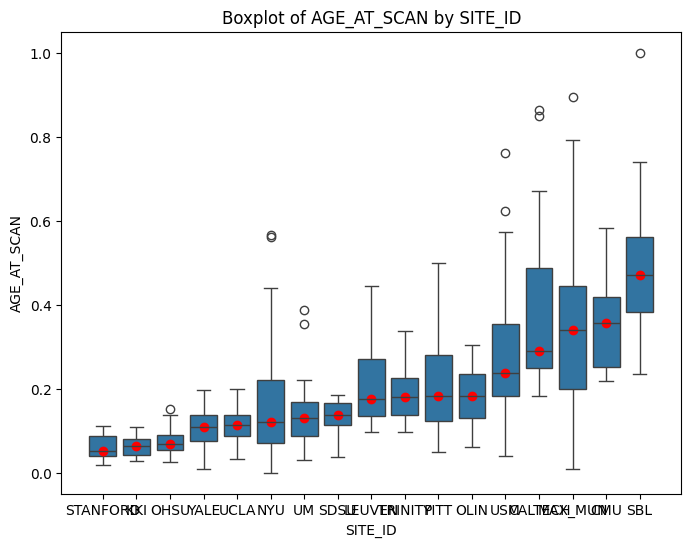

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


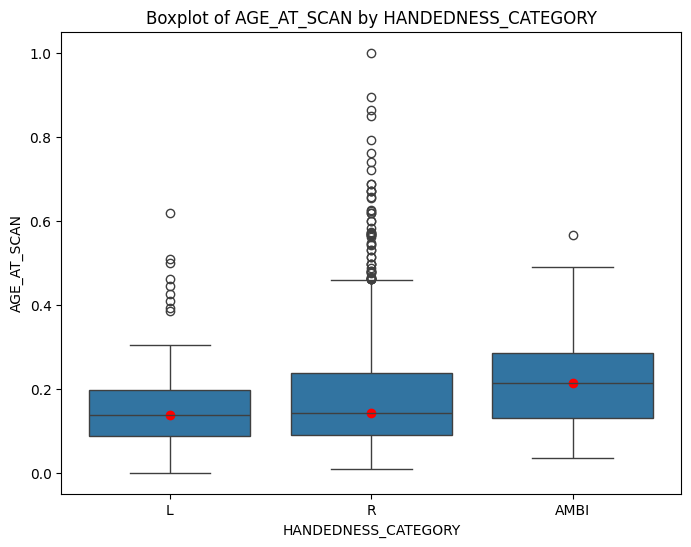

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


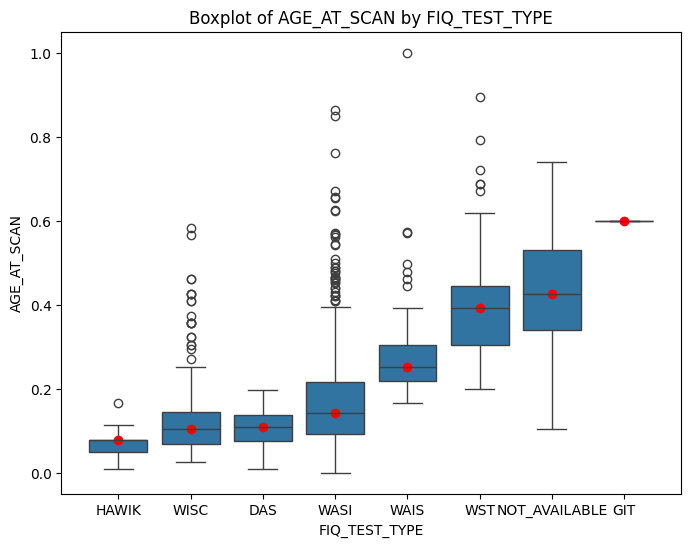

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


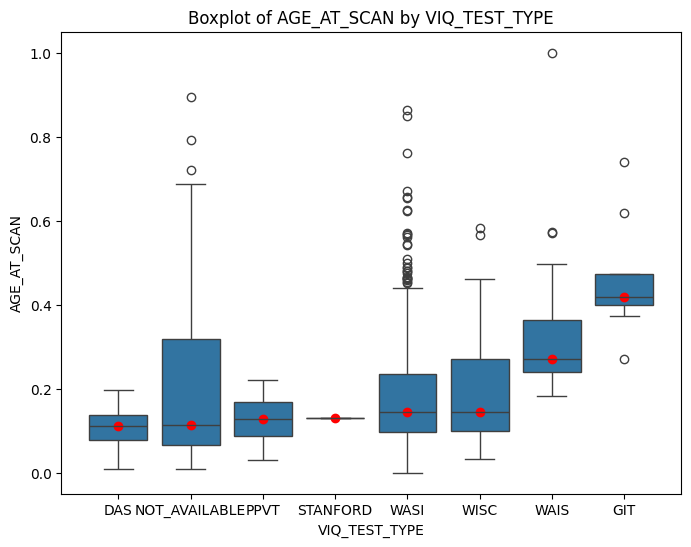

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


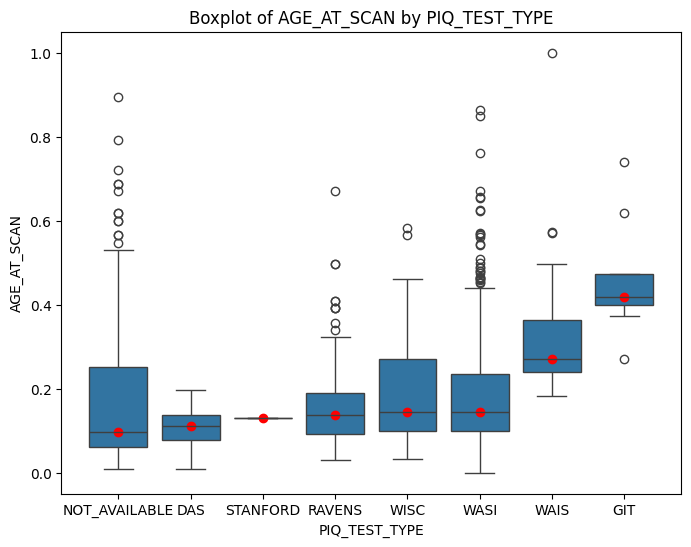

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


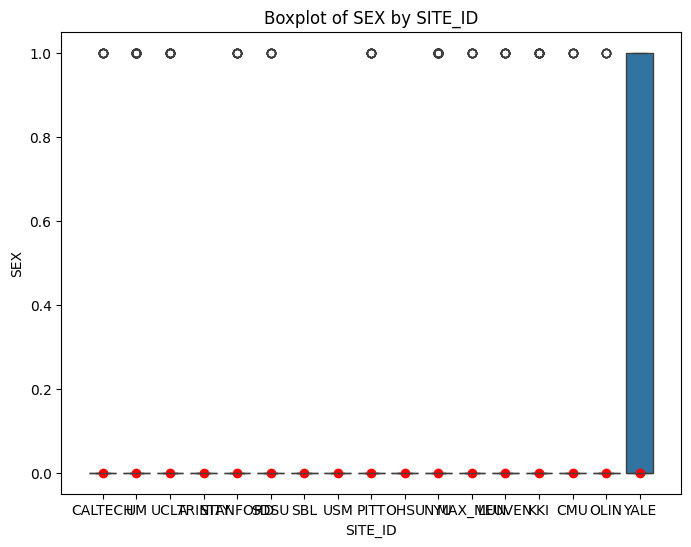

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


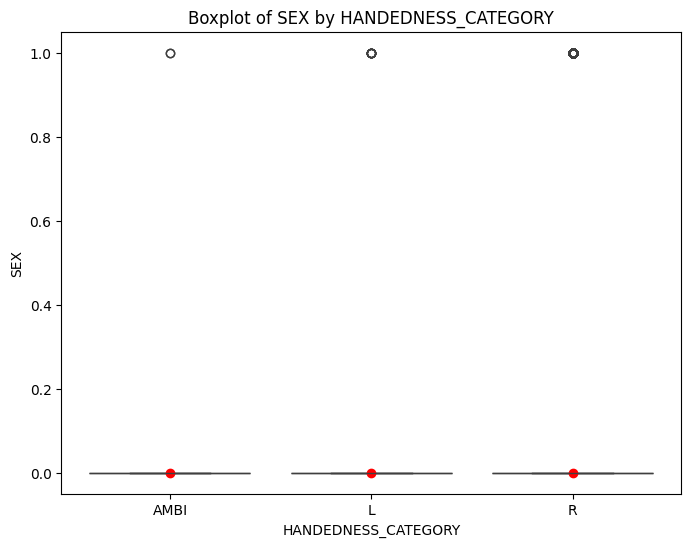

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


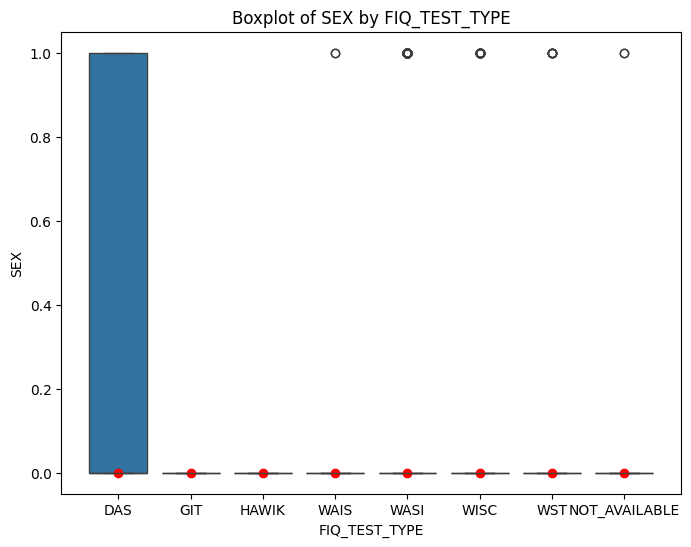

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


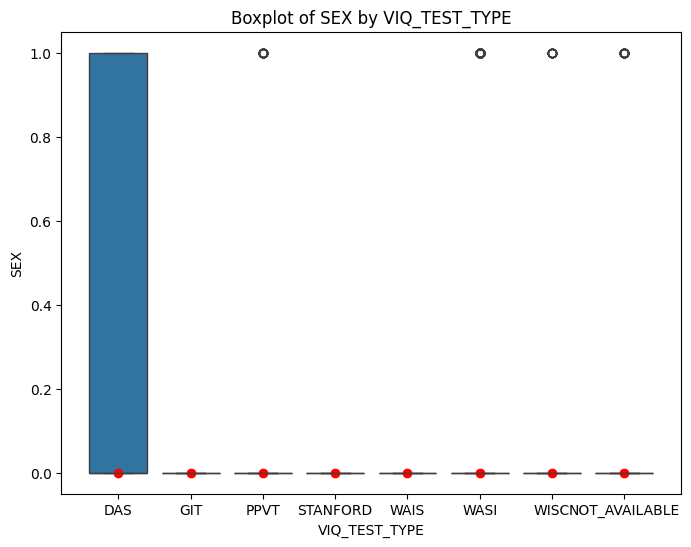

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


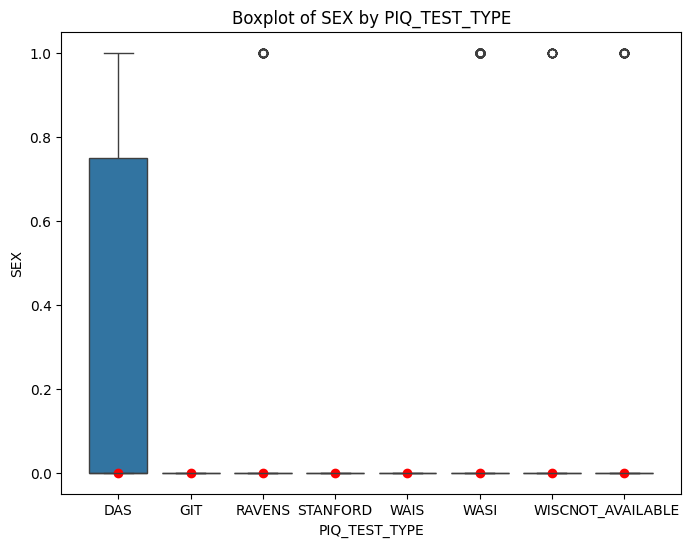

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


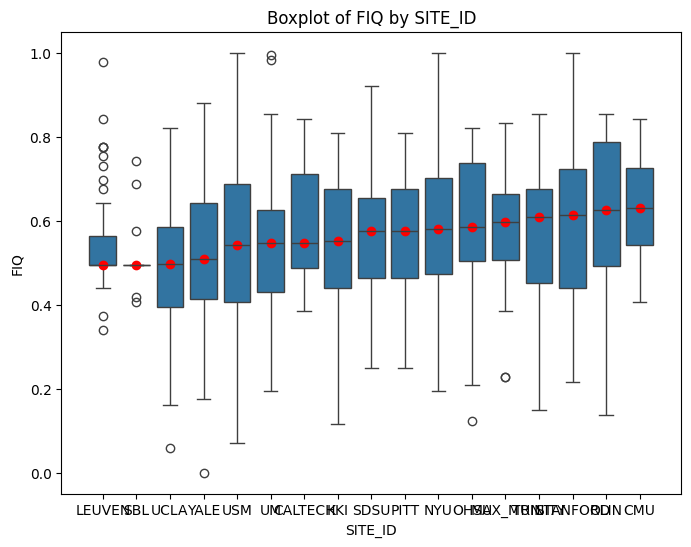

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


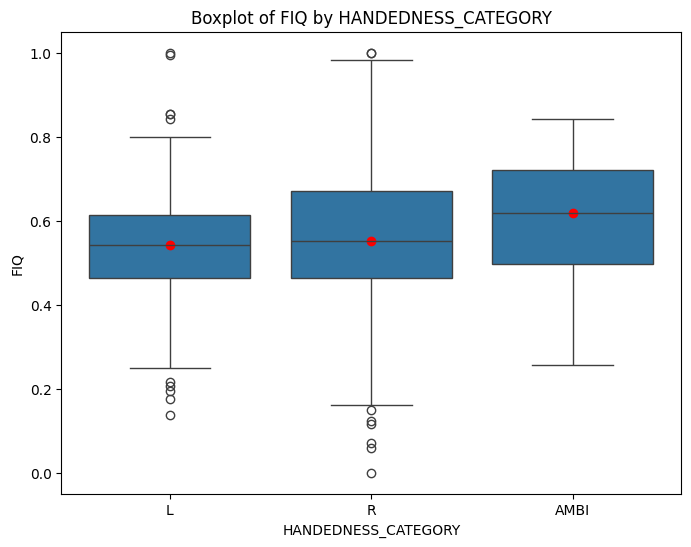

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


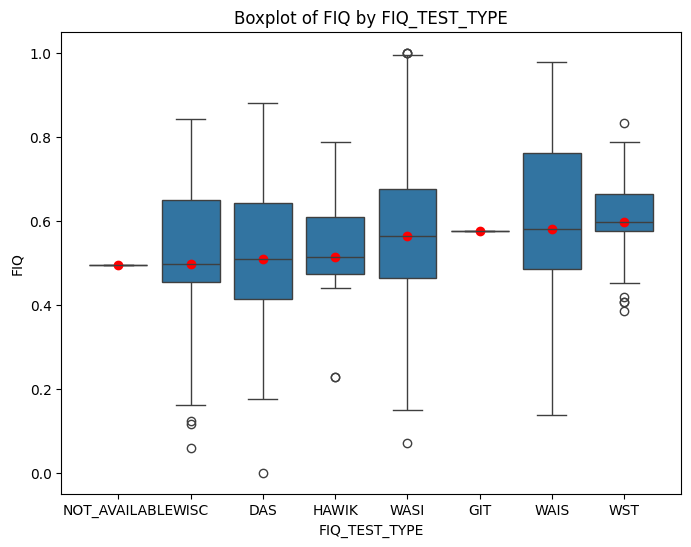

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


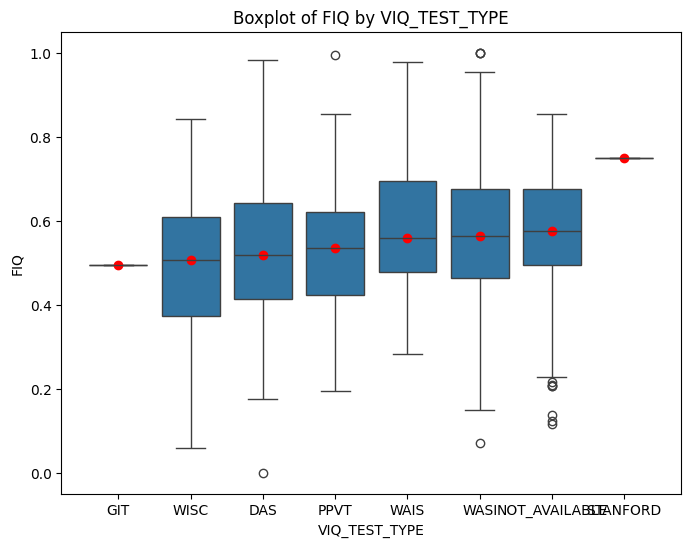

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


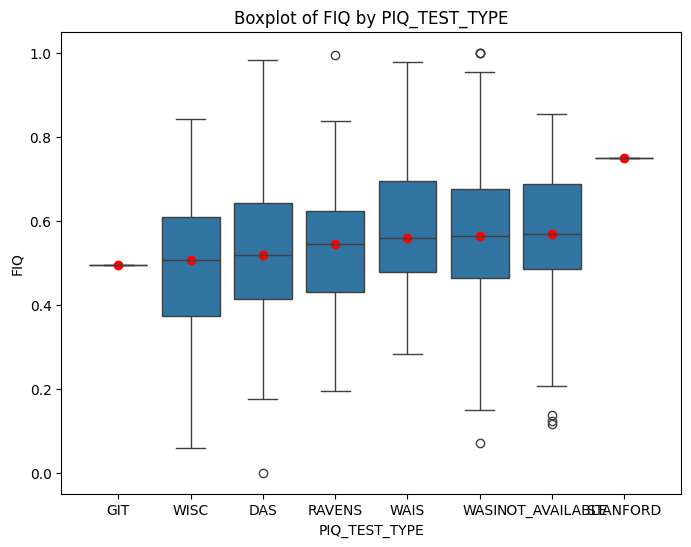

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


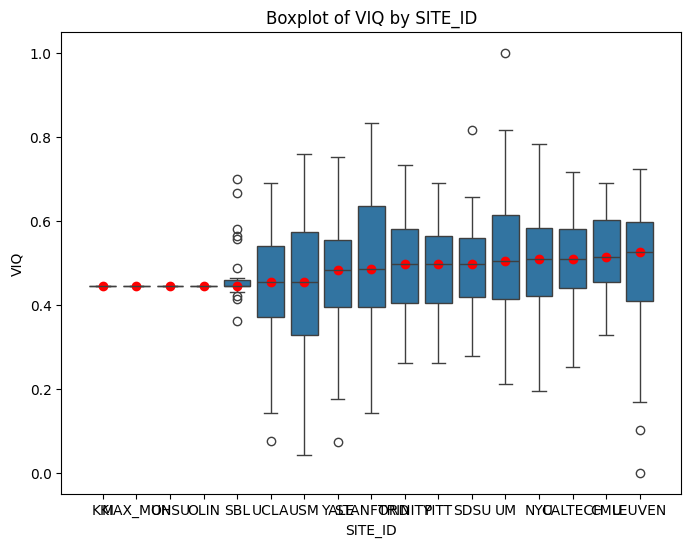

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


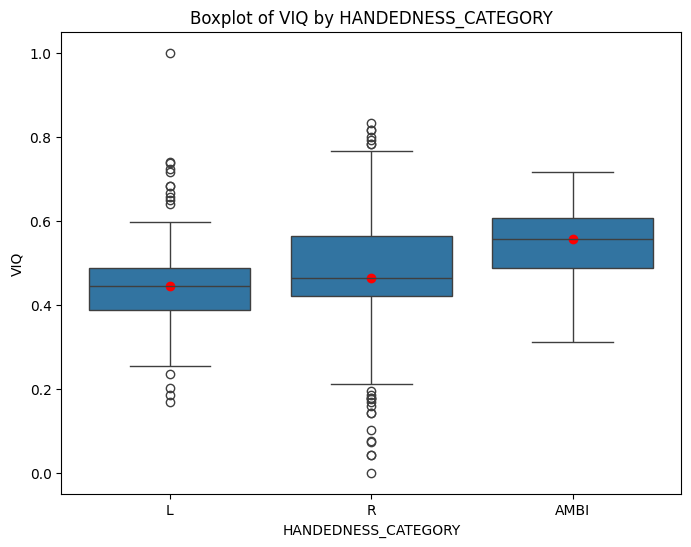

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


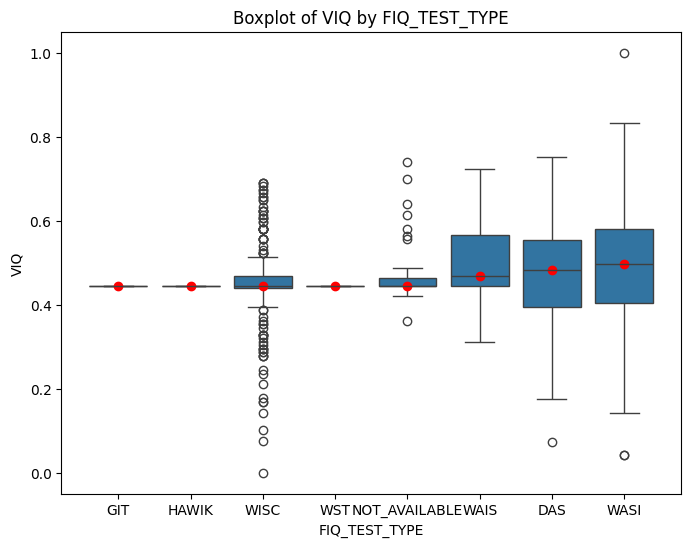

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


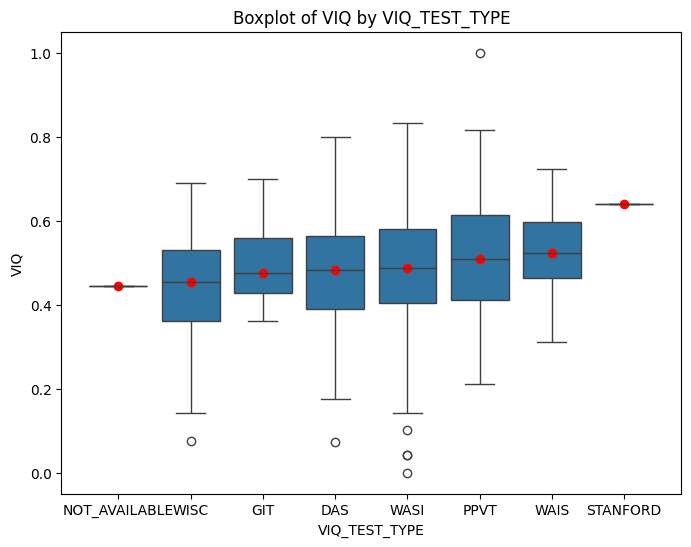

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


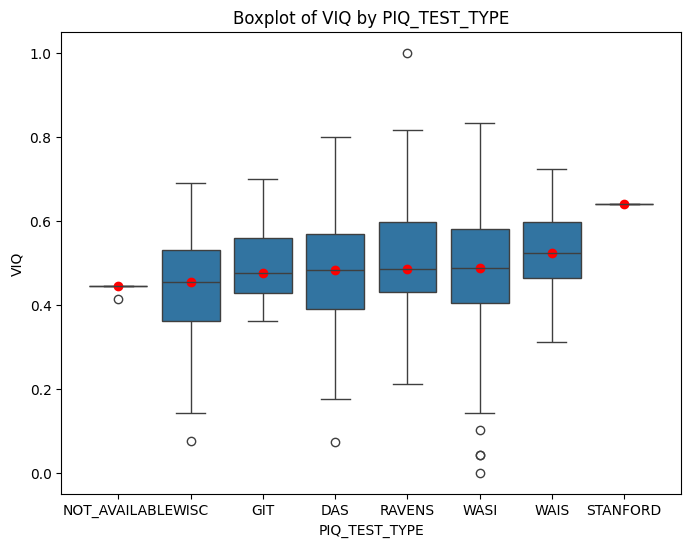

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


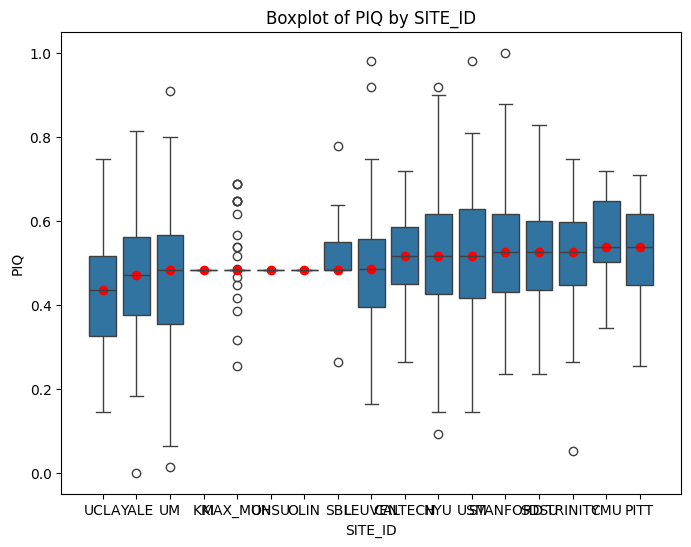

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


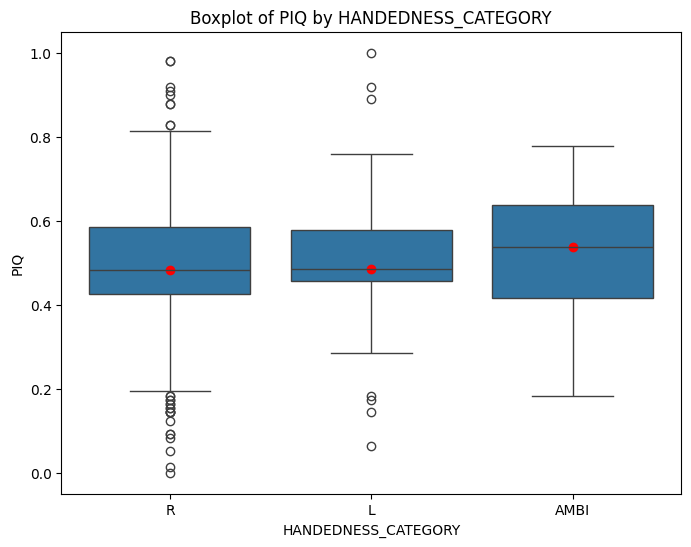

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


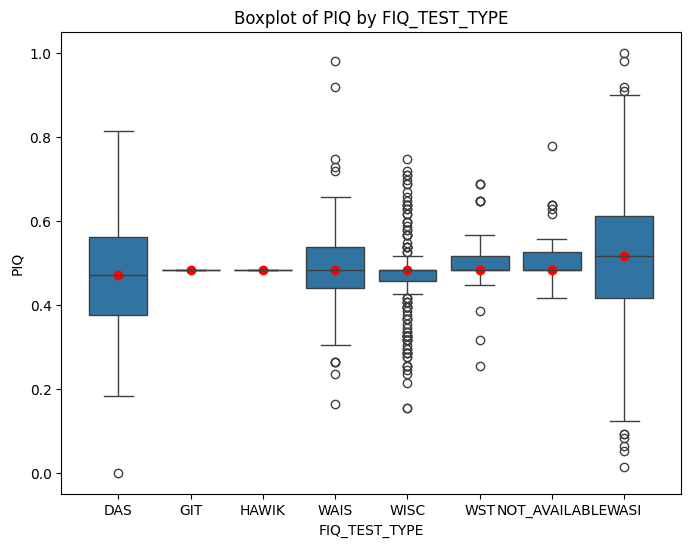

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


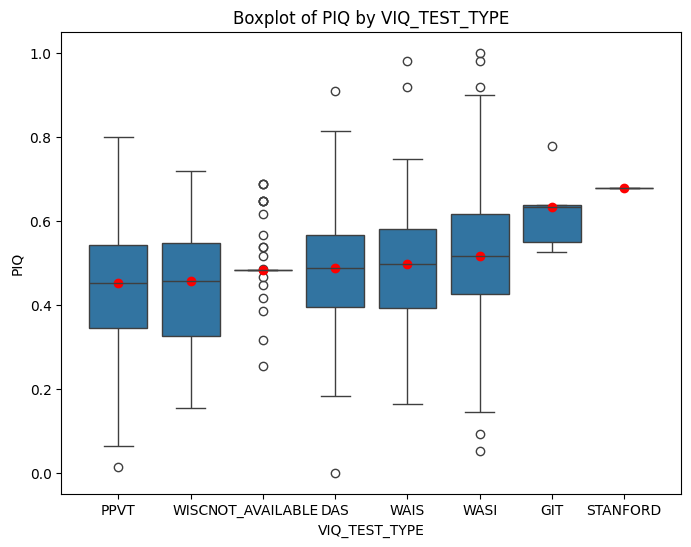

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


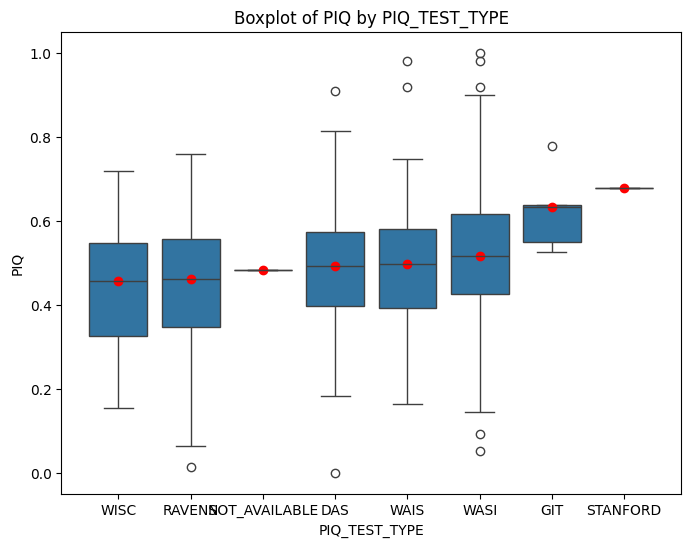

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


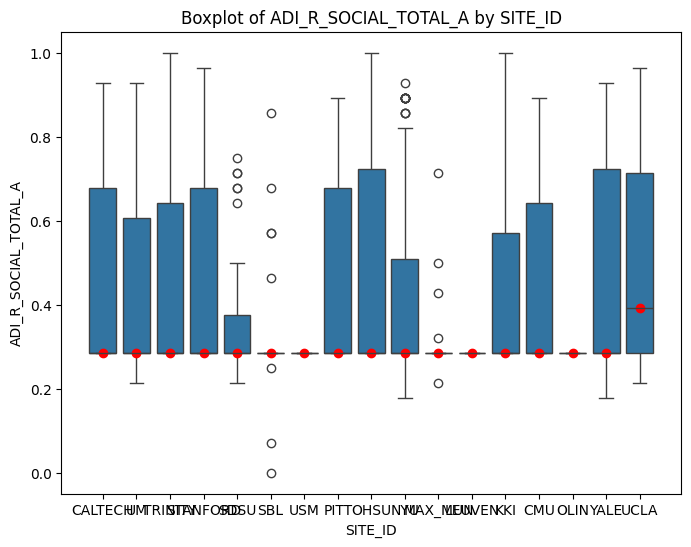

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


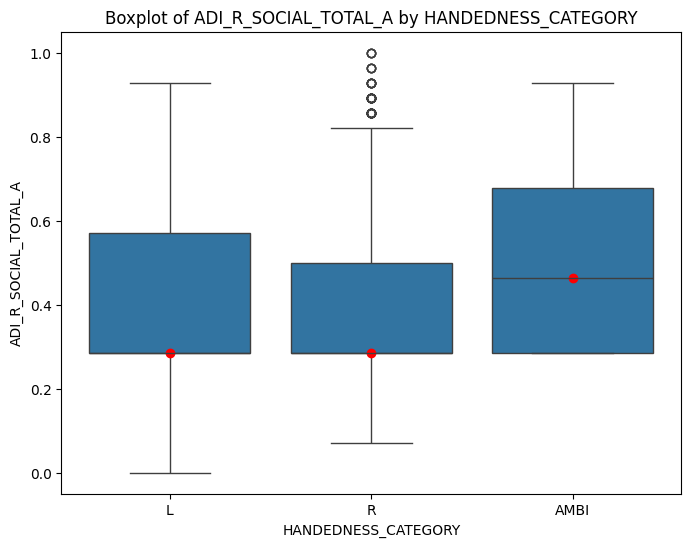

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


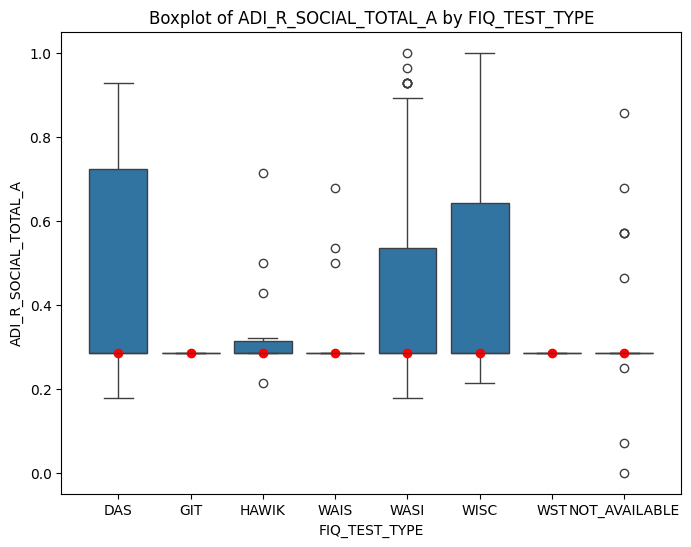

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


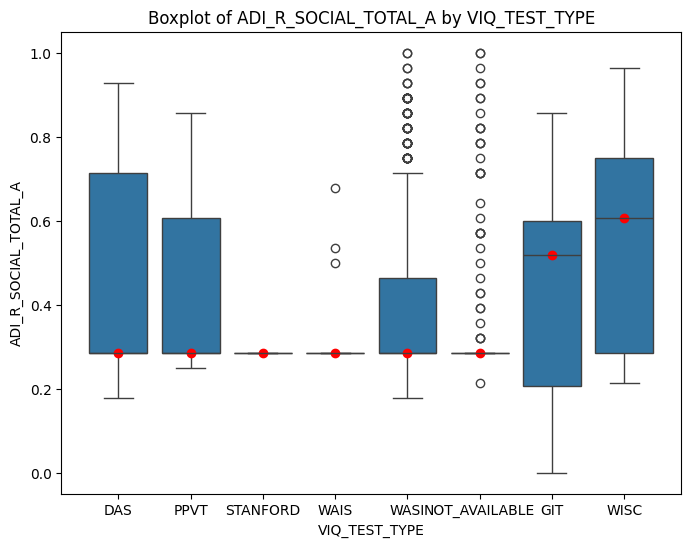

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


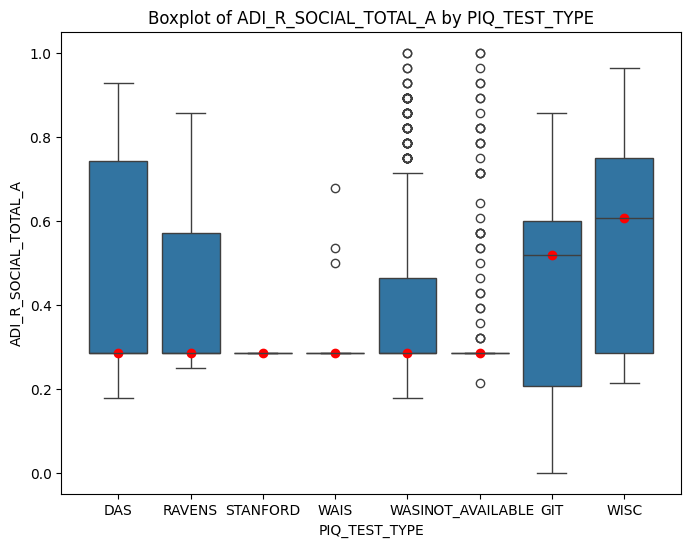

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


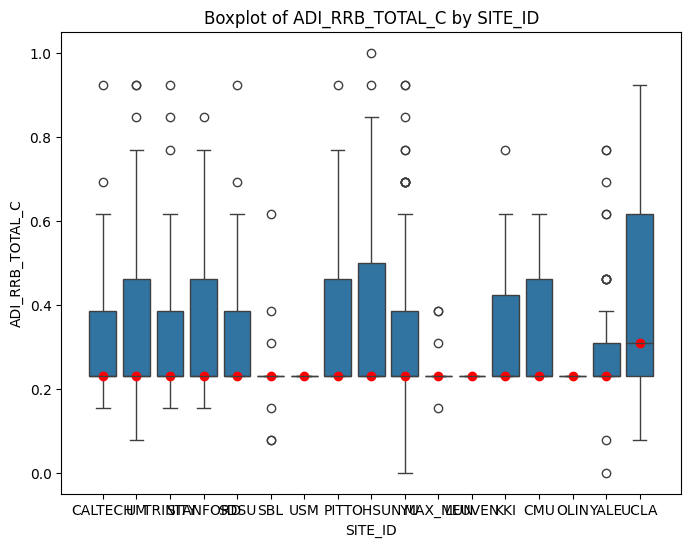

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


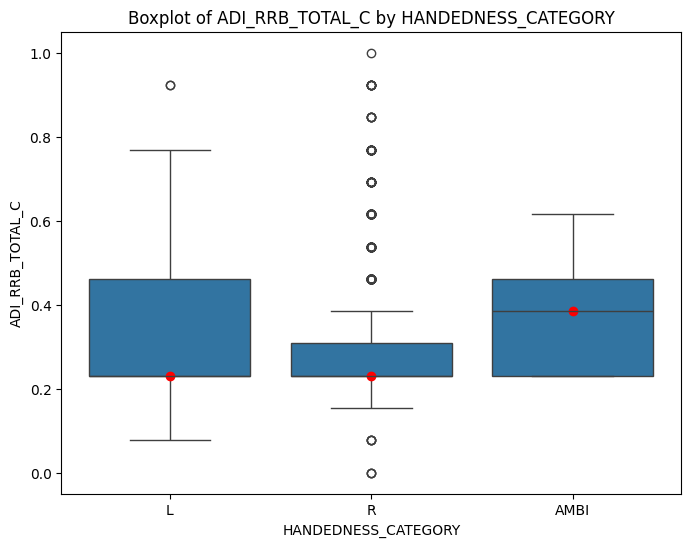

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


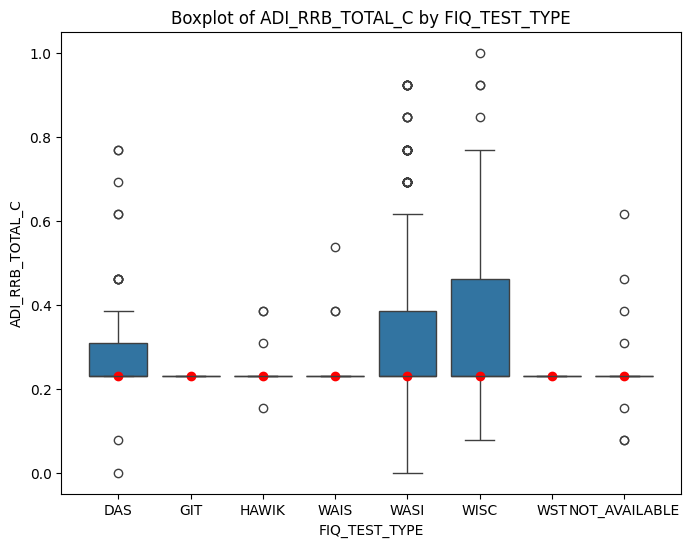

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


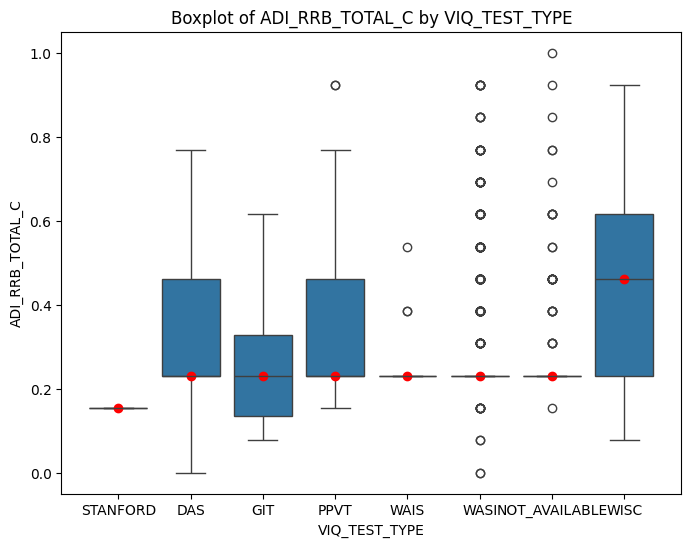

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


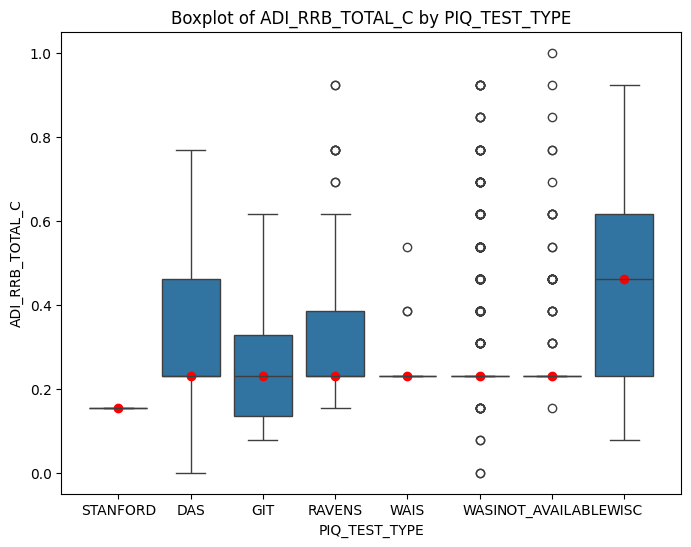

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


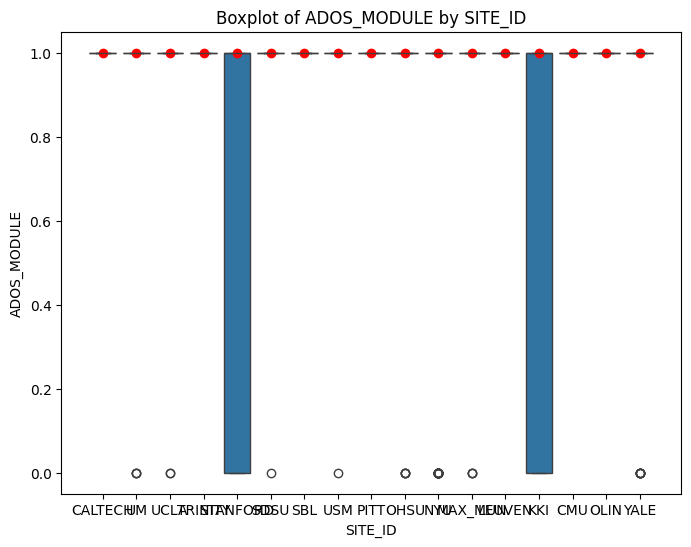

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


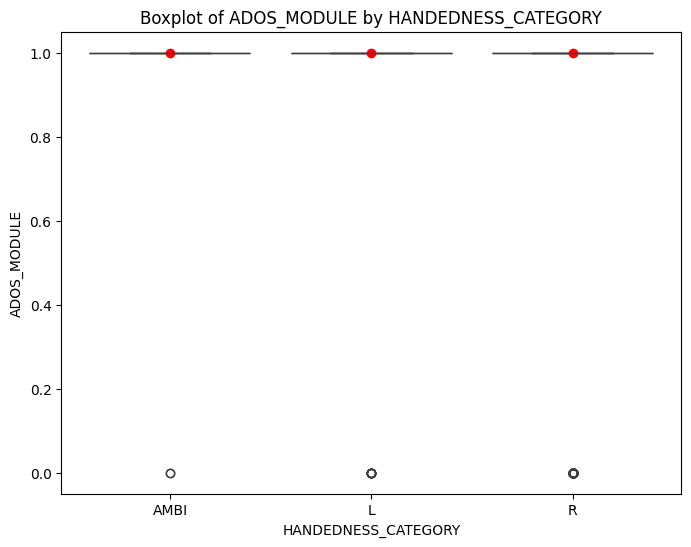

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


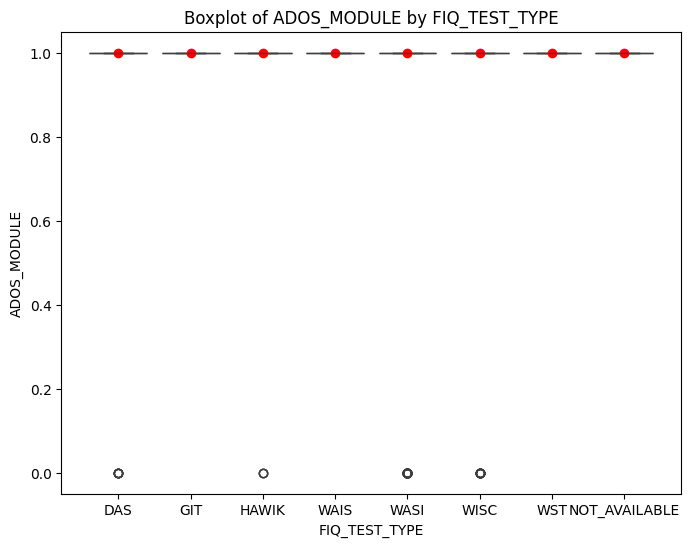

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


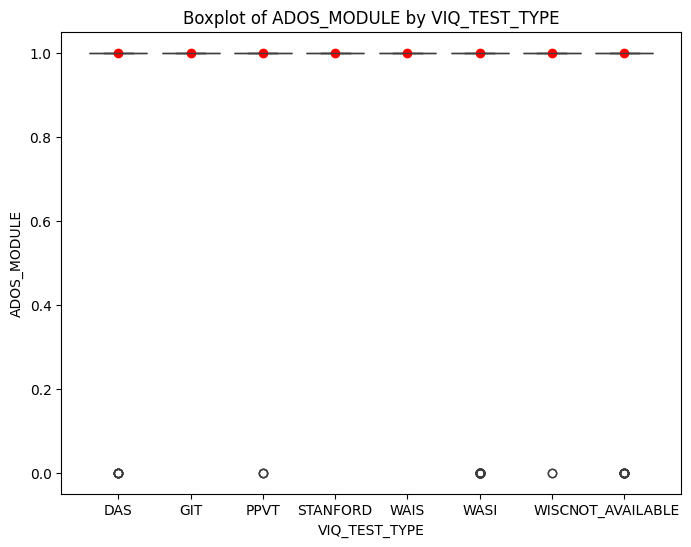

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


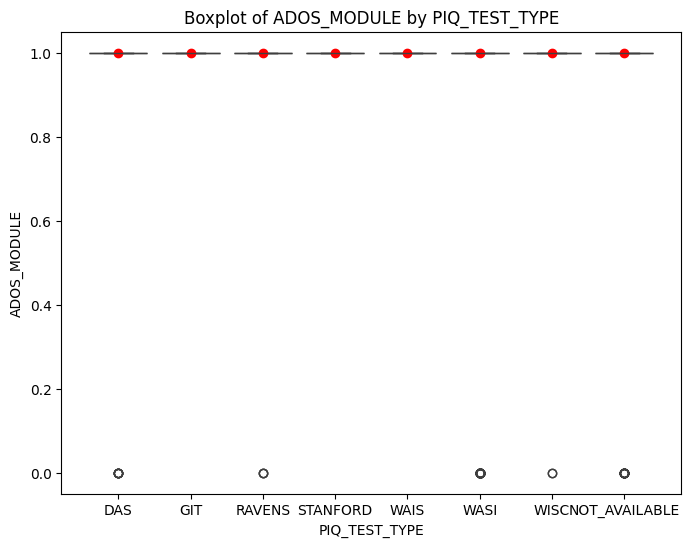

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


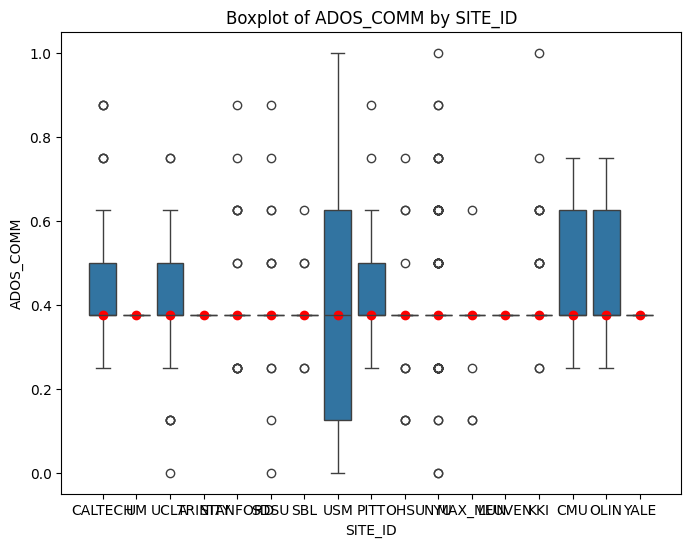

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


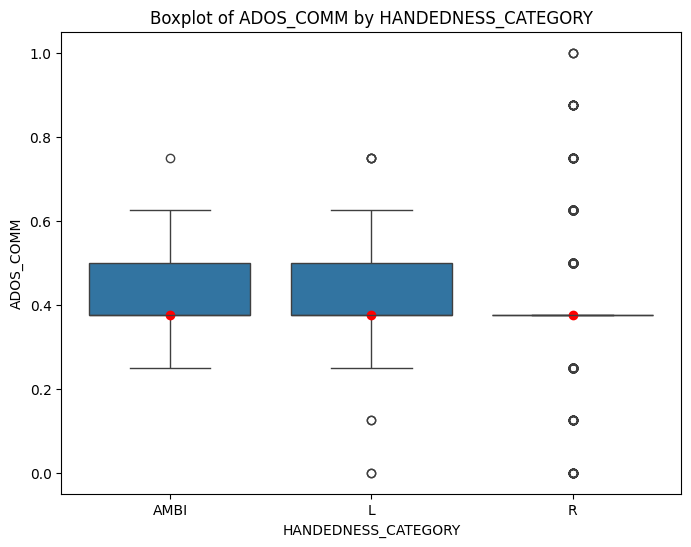

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


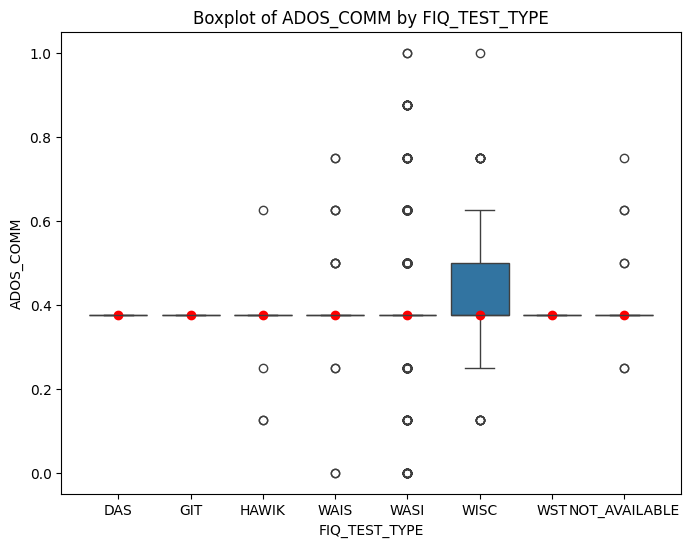

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


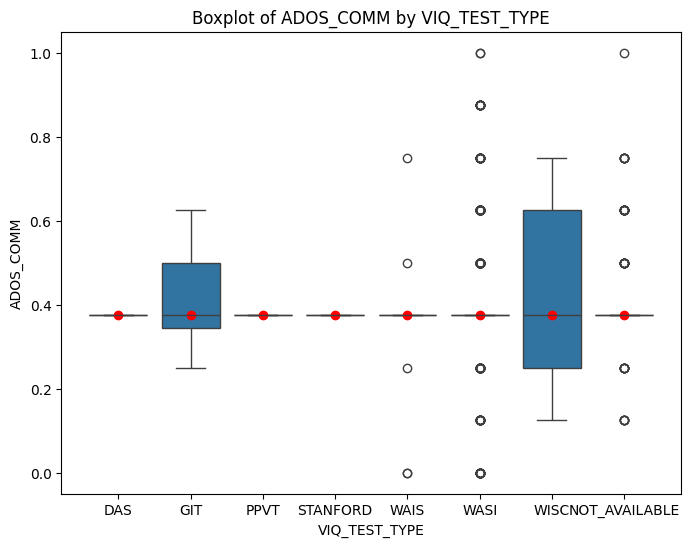

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


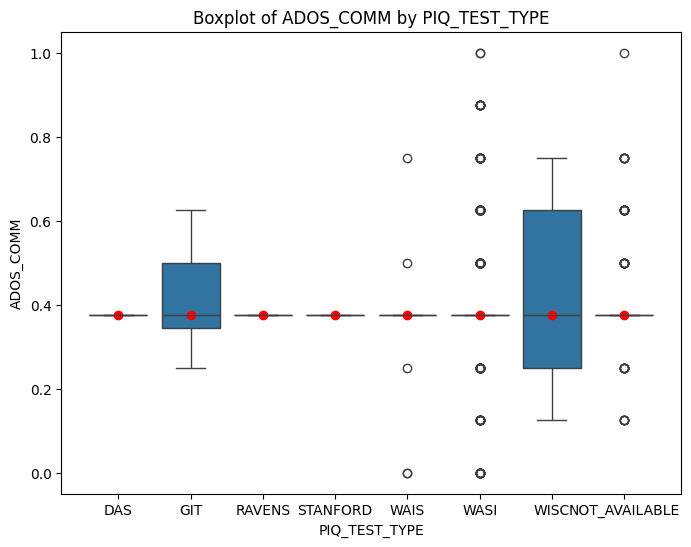

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


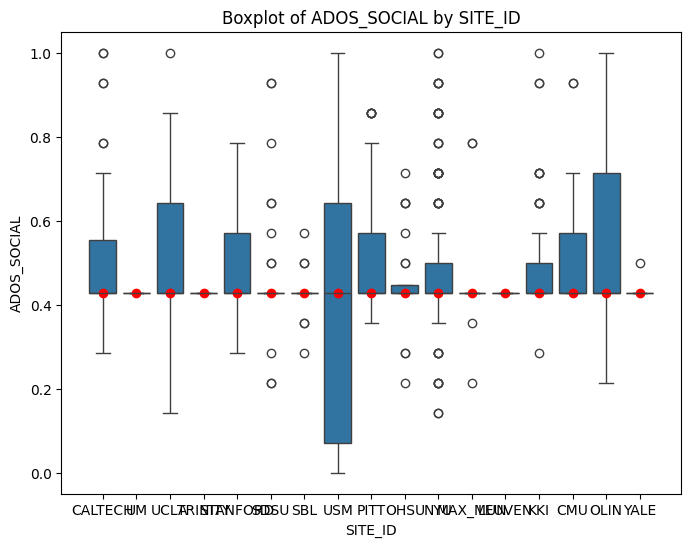

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


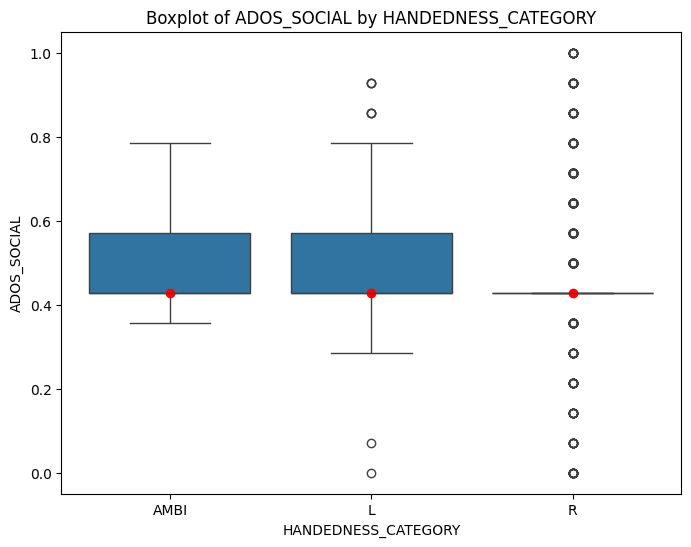

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


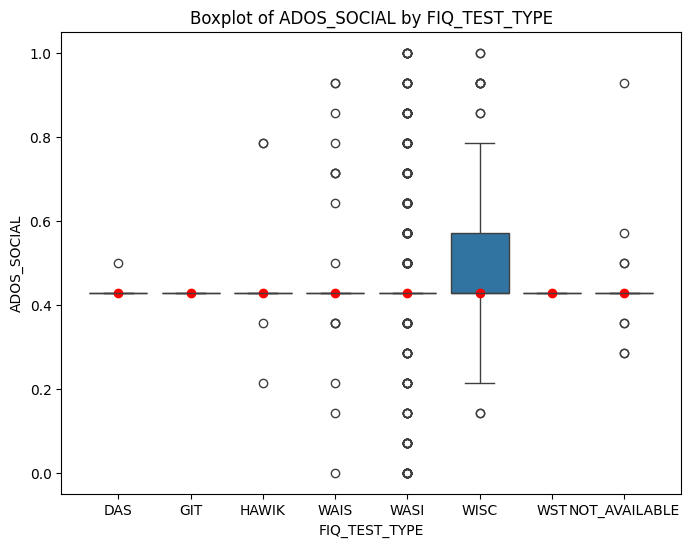

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


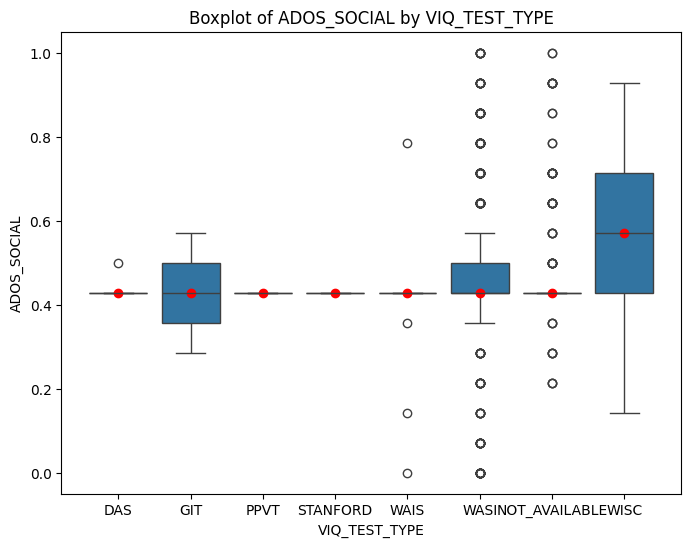

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


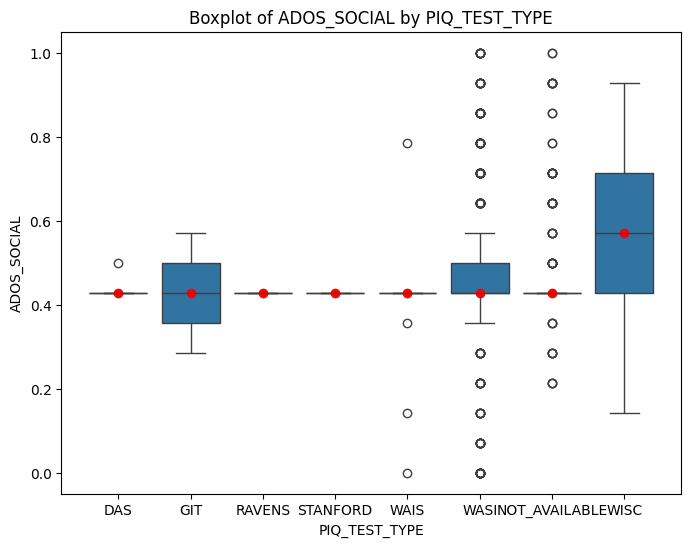

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


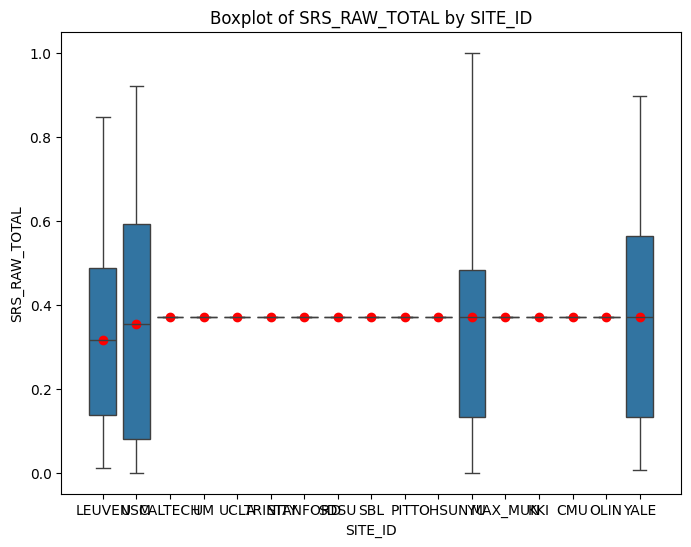

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


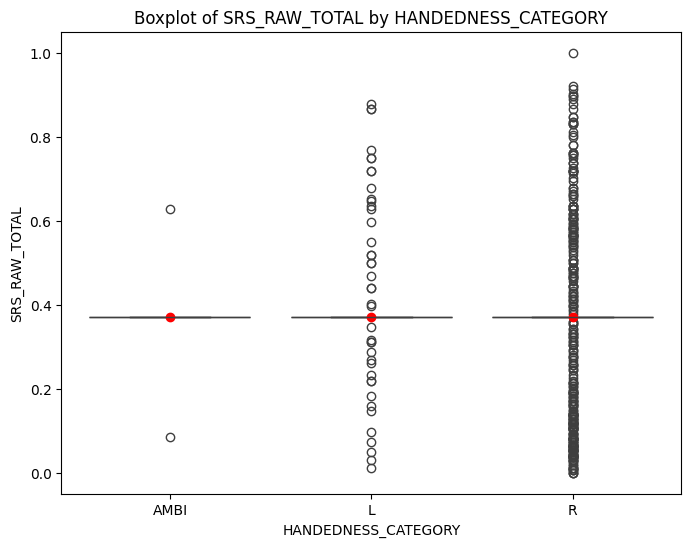

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


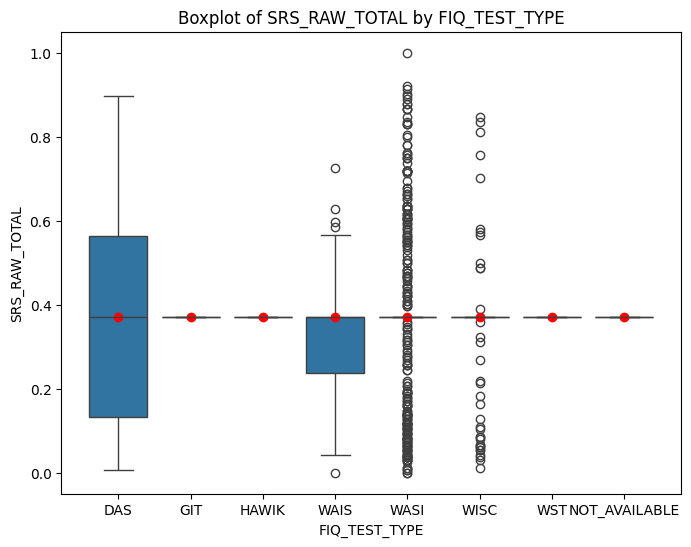

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


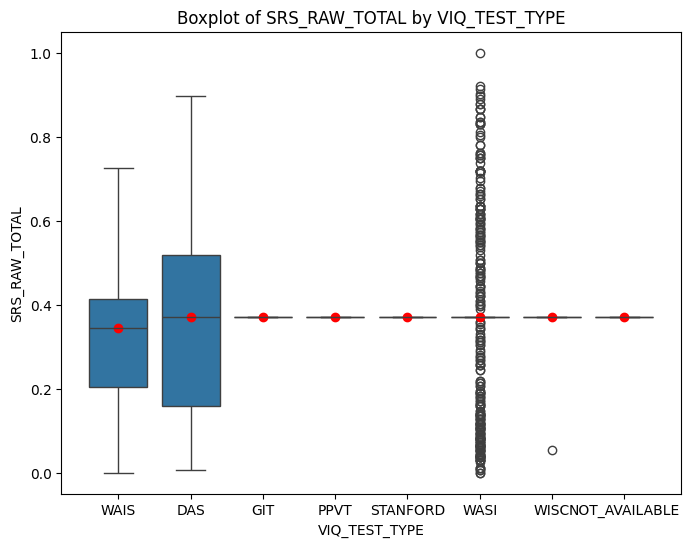

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


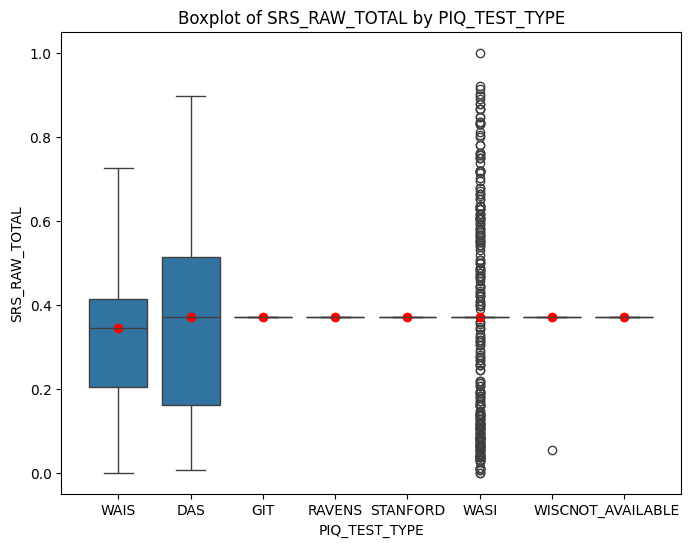

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


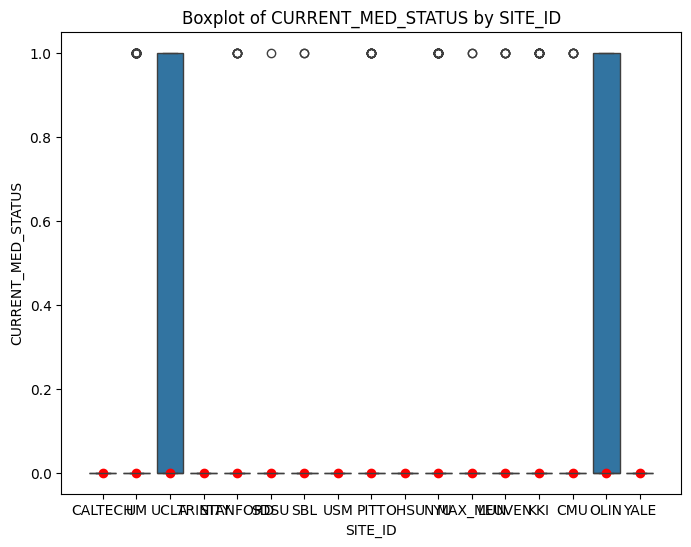

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


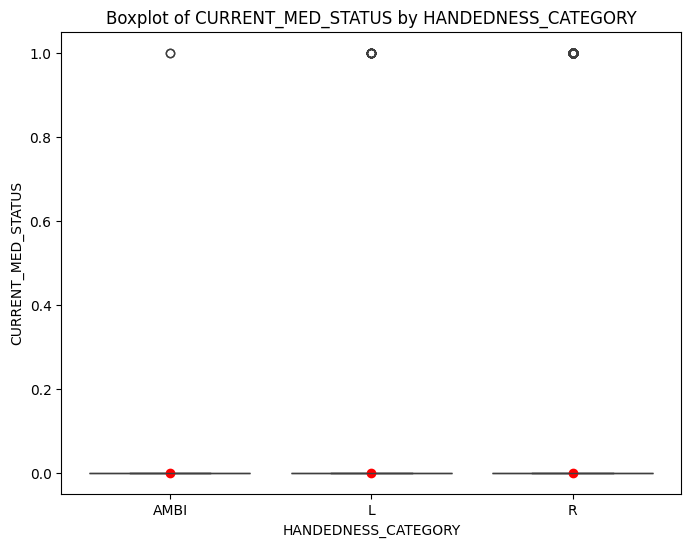

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


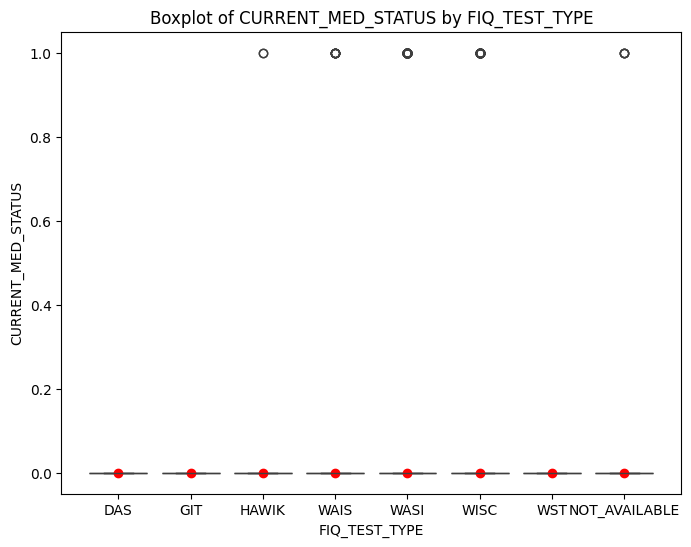

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


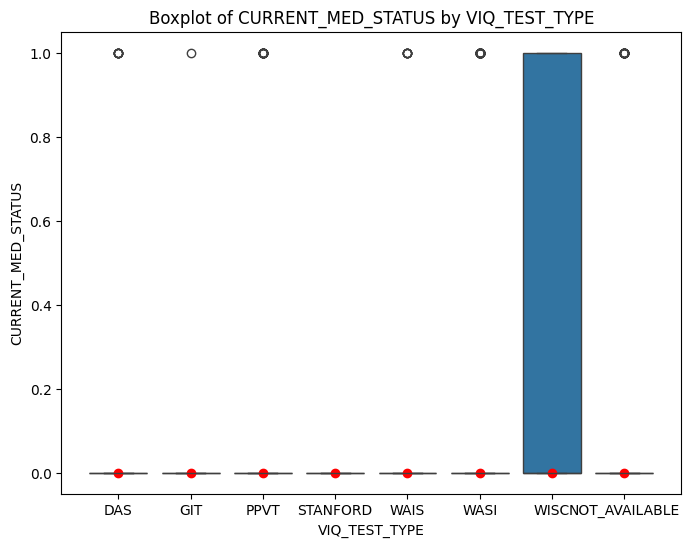

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


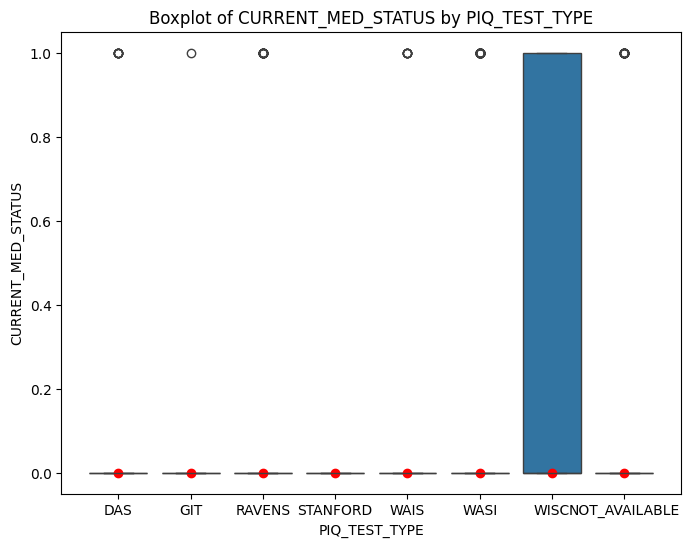

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


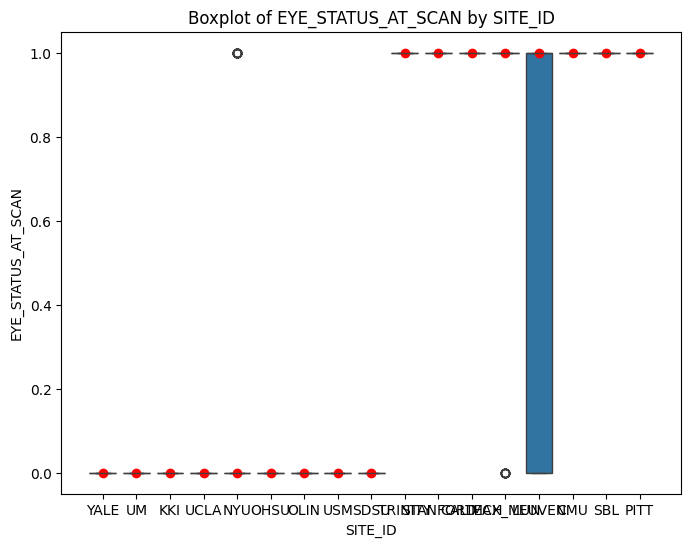

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


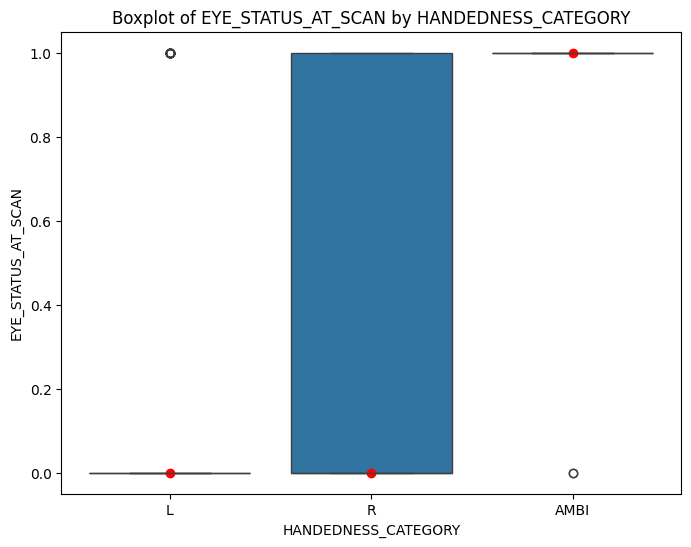

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


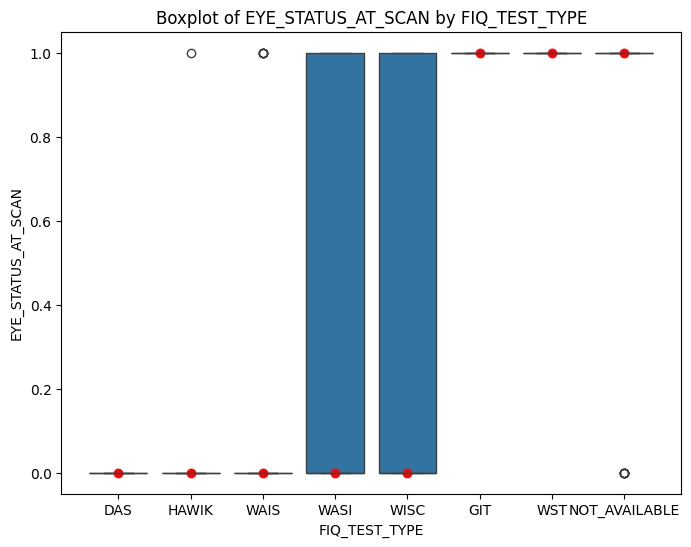

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


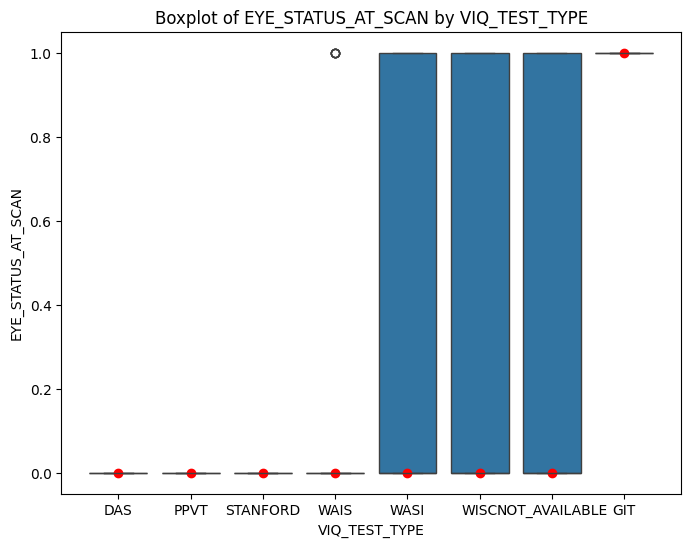

C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
C:\Users\nical\AppData\Local\Temp\ipykernel_11160\110334466.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()


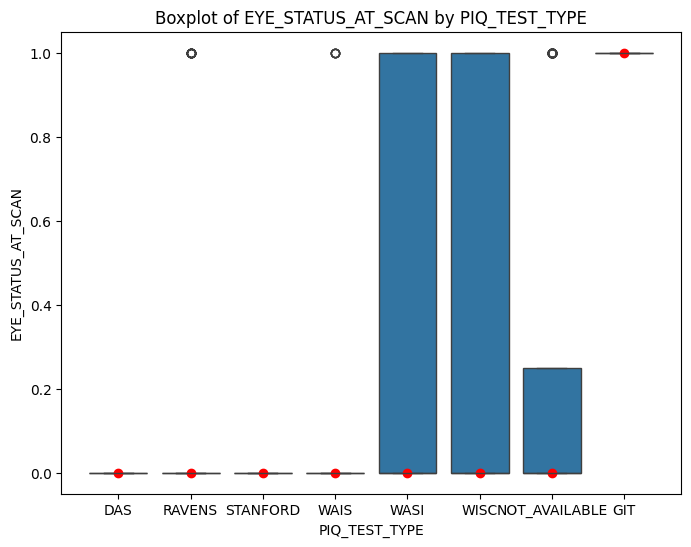

In [555]:
# Creiamo un boxplot per ogni feature numerica e categorica
for numeric_col in numeric_columns:
    for cat_col in categorical_columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic_normalized, order=ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values().index)
        
        # Evidenziamo la mediana in rosso
        median = ASD_phenotypic_normalized.groupby(cat_col)[numeric_col].median().sort_values()
        for i in range(len(median)):
            plt.plot(i, median.iloc[i], 'ro')
        
        plt.title(f'Boxplot of {numeric_col} by {cat_col}')
        plt.xlabel(cat_col)
        plt.ylabel(numeric_col)
        plt.show()
